In [1]:
import pyPyrTools as ppt
import sys
import numpy as np
sys.path.append('..')
import sfp
%matplotlib inline
import seaborn as sns
from pyPyrTools import JBhelpers as jbh
import pandas as pd
from scipy import signal
import fractions

The following demonstrates some of the stimuli that can be made with the `log_polar_grating` command. The key characteristic of these stimuli is that the frequency (in cycles per pixel) increases as you approach the center of the image. This encodes our hypothesis that the preferred spatial frequency of neurons (and thus, voxels) whose receptive fields are located at the fovea (here, the center of the image) will have a higher preferred spatial frequency than those whose receptive fields are located in the periphery.

However, with these parameters, we notice that there is strange-looking aliasing happening in the center of the image.


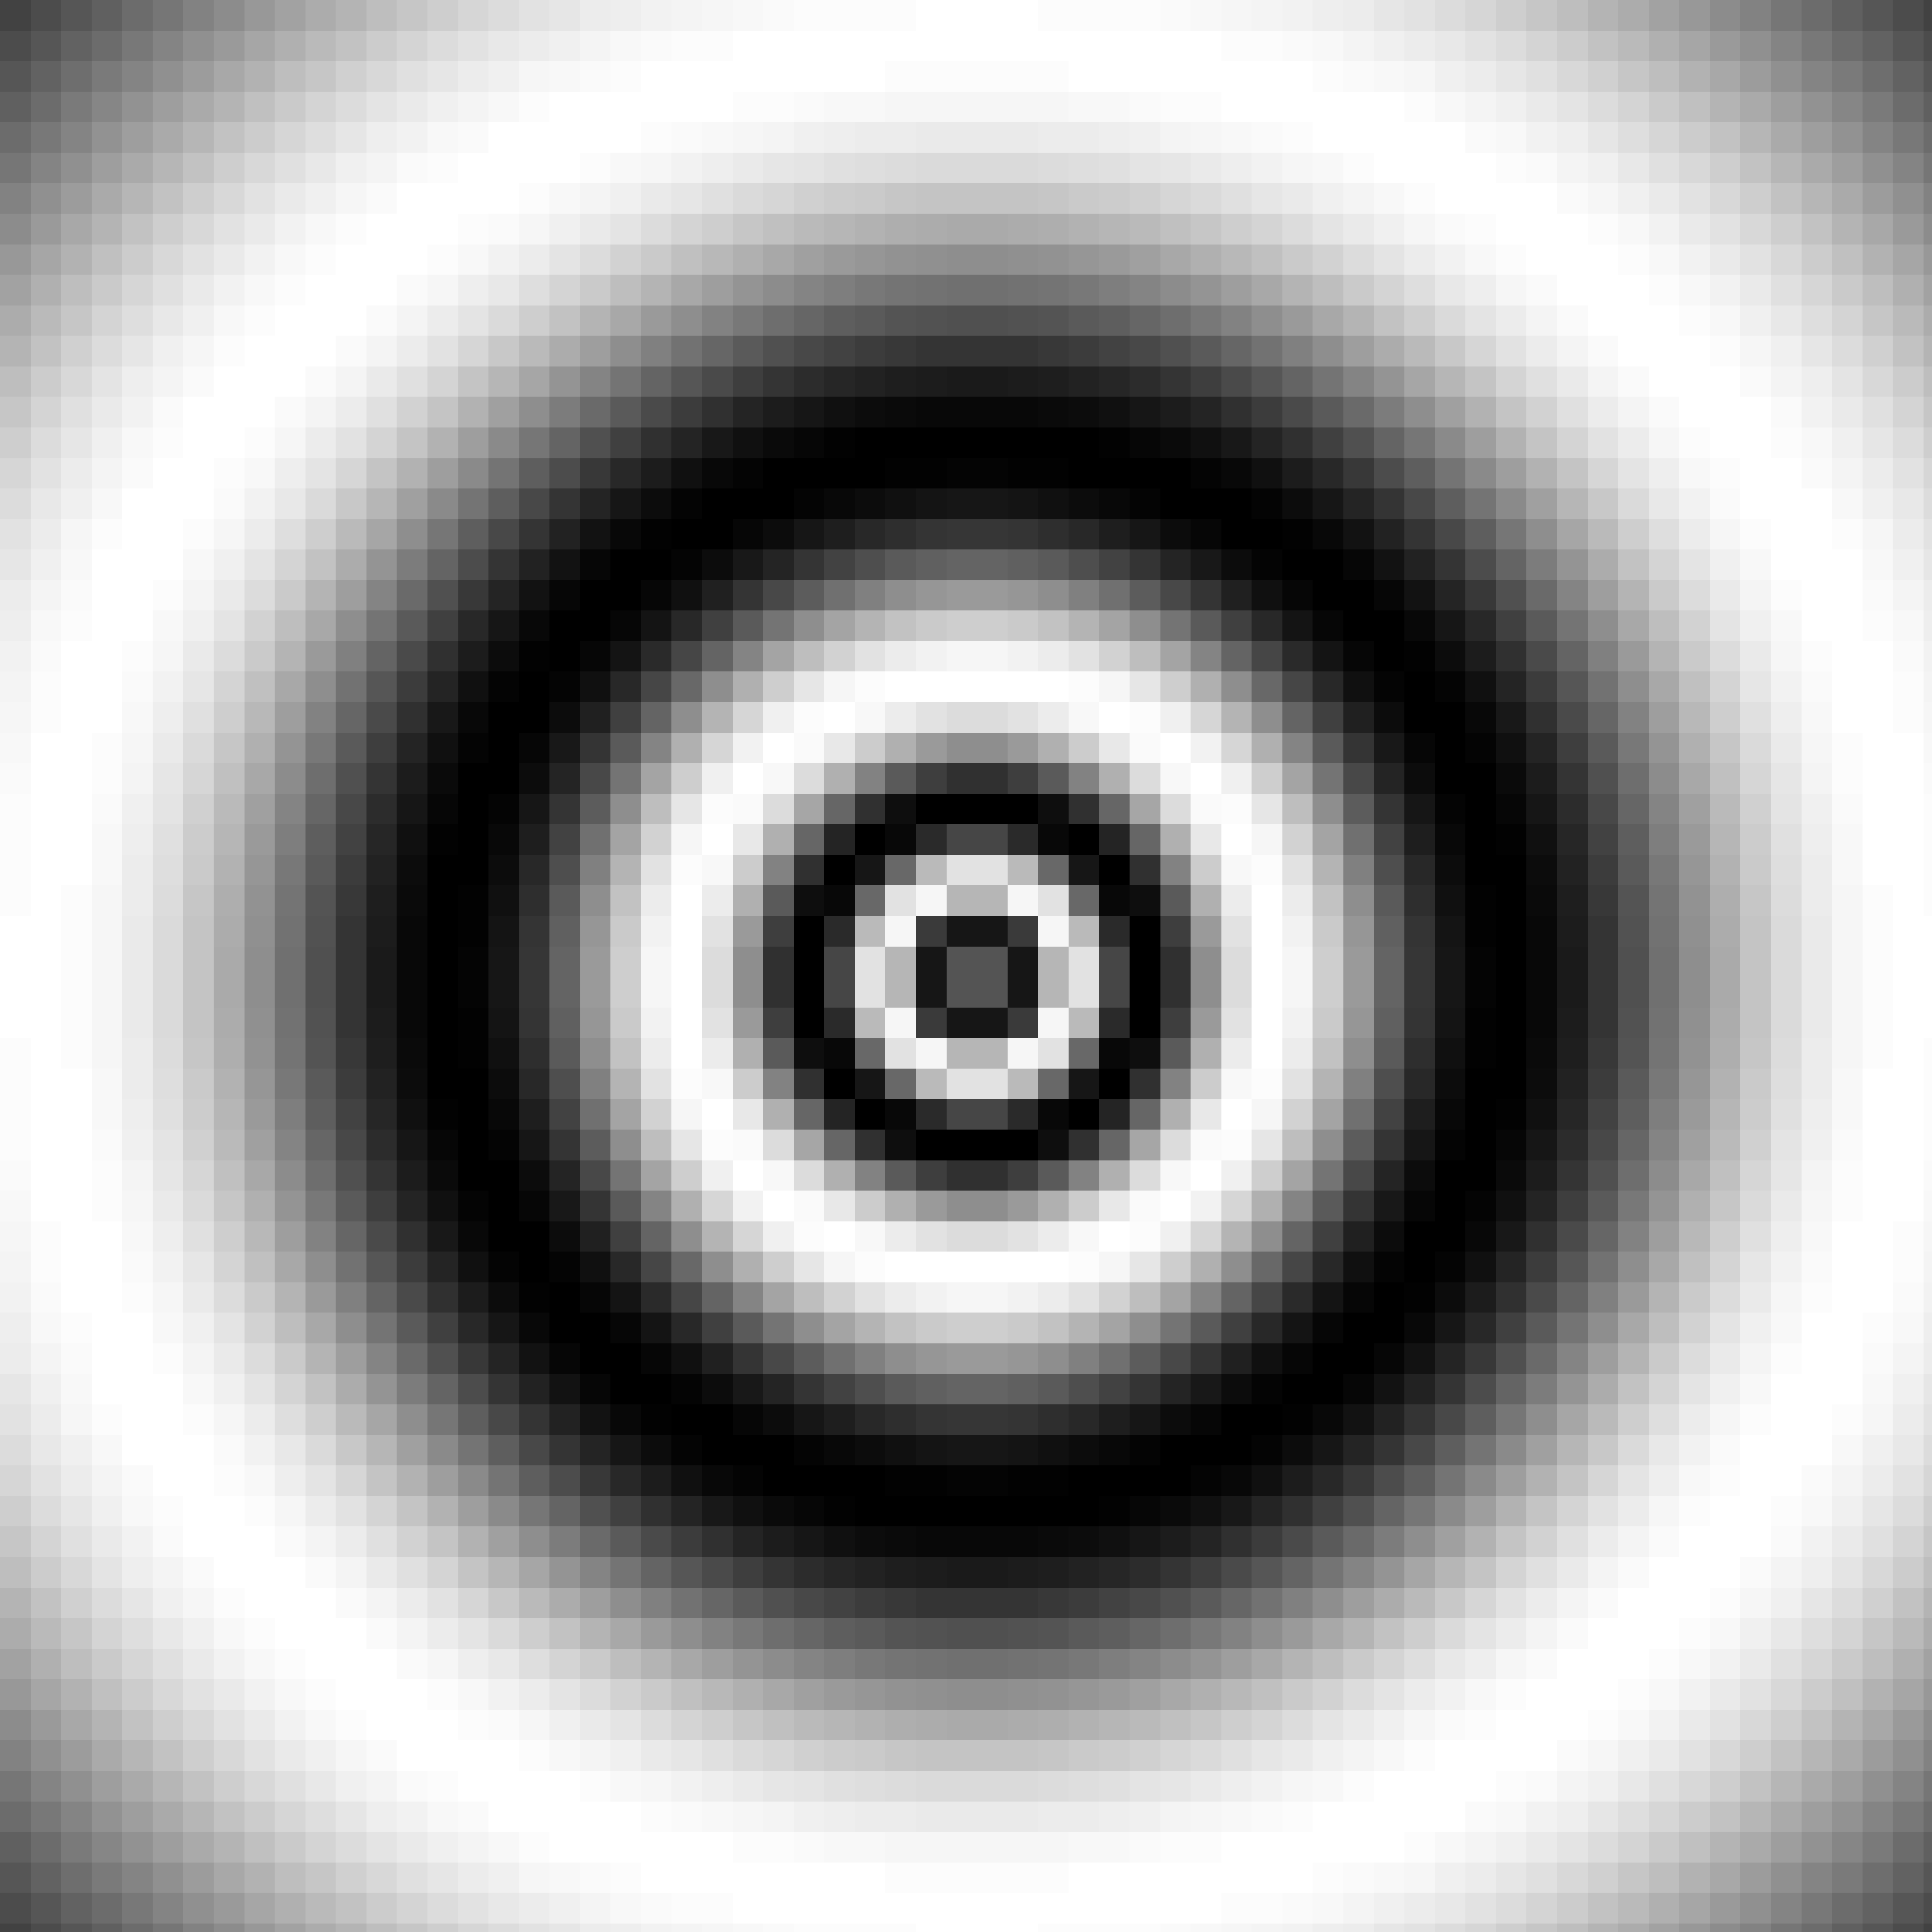
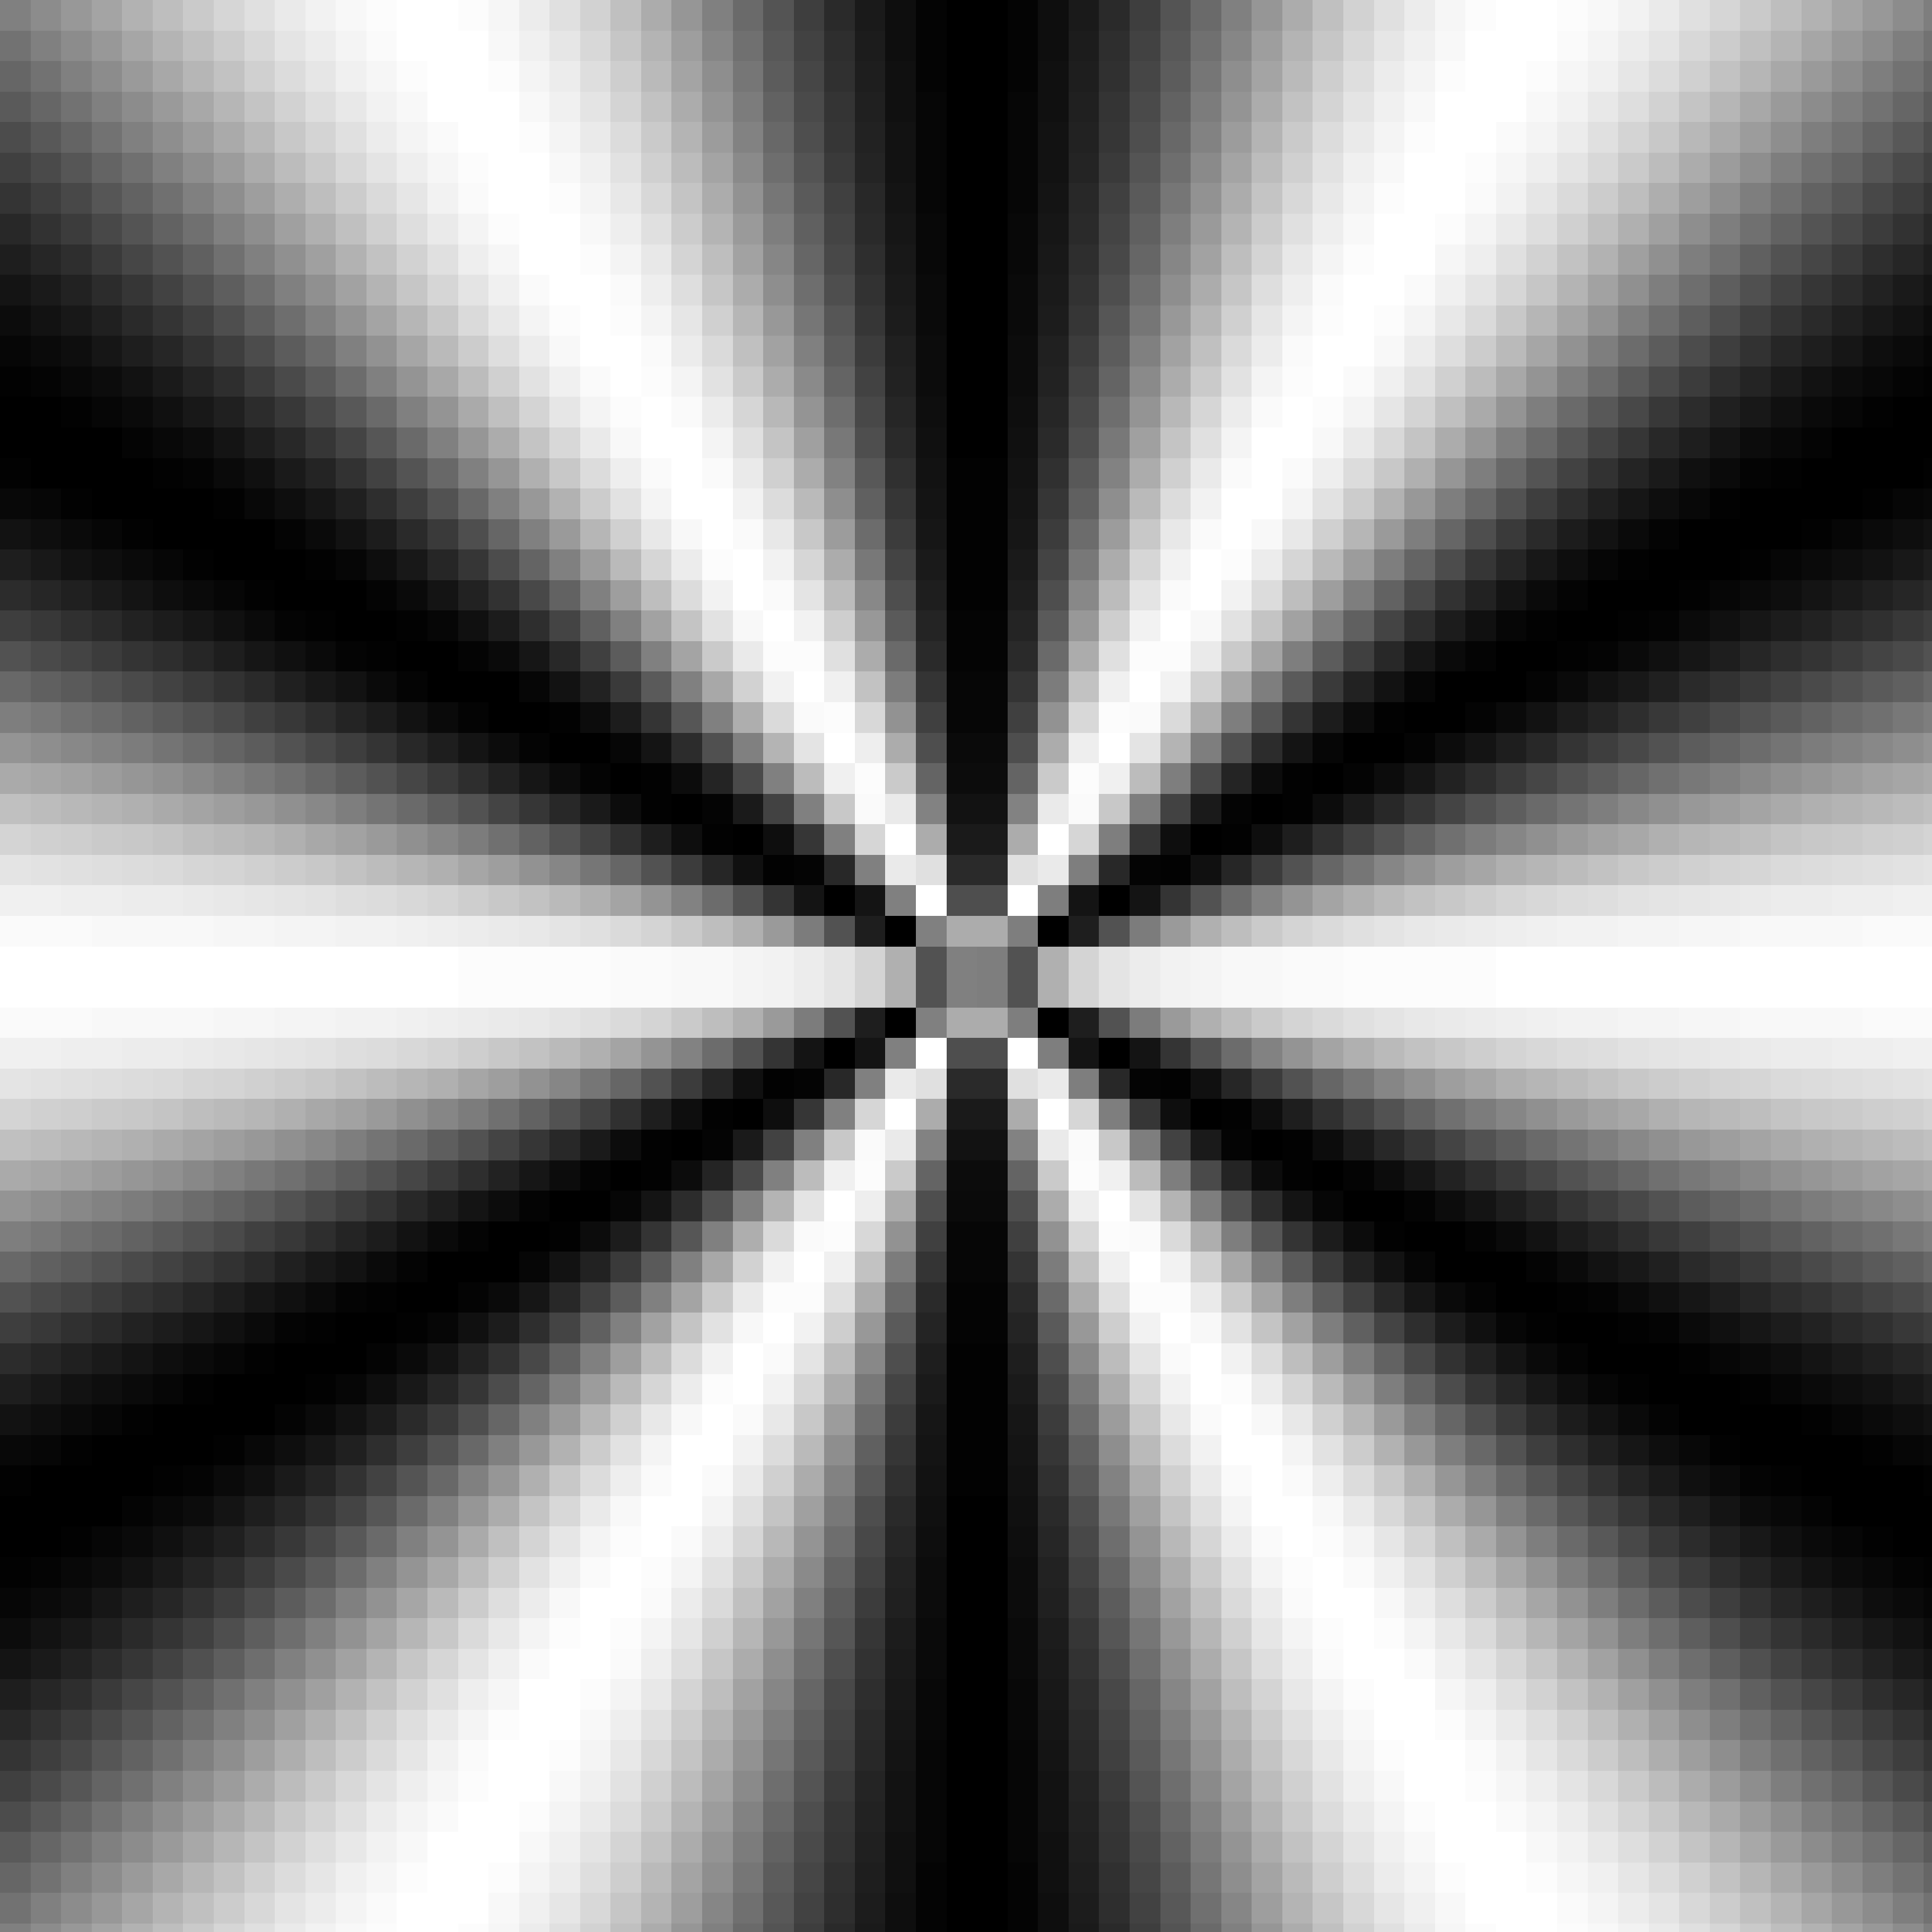
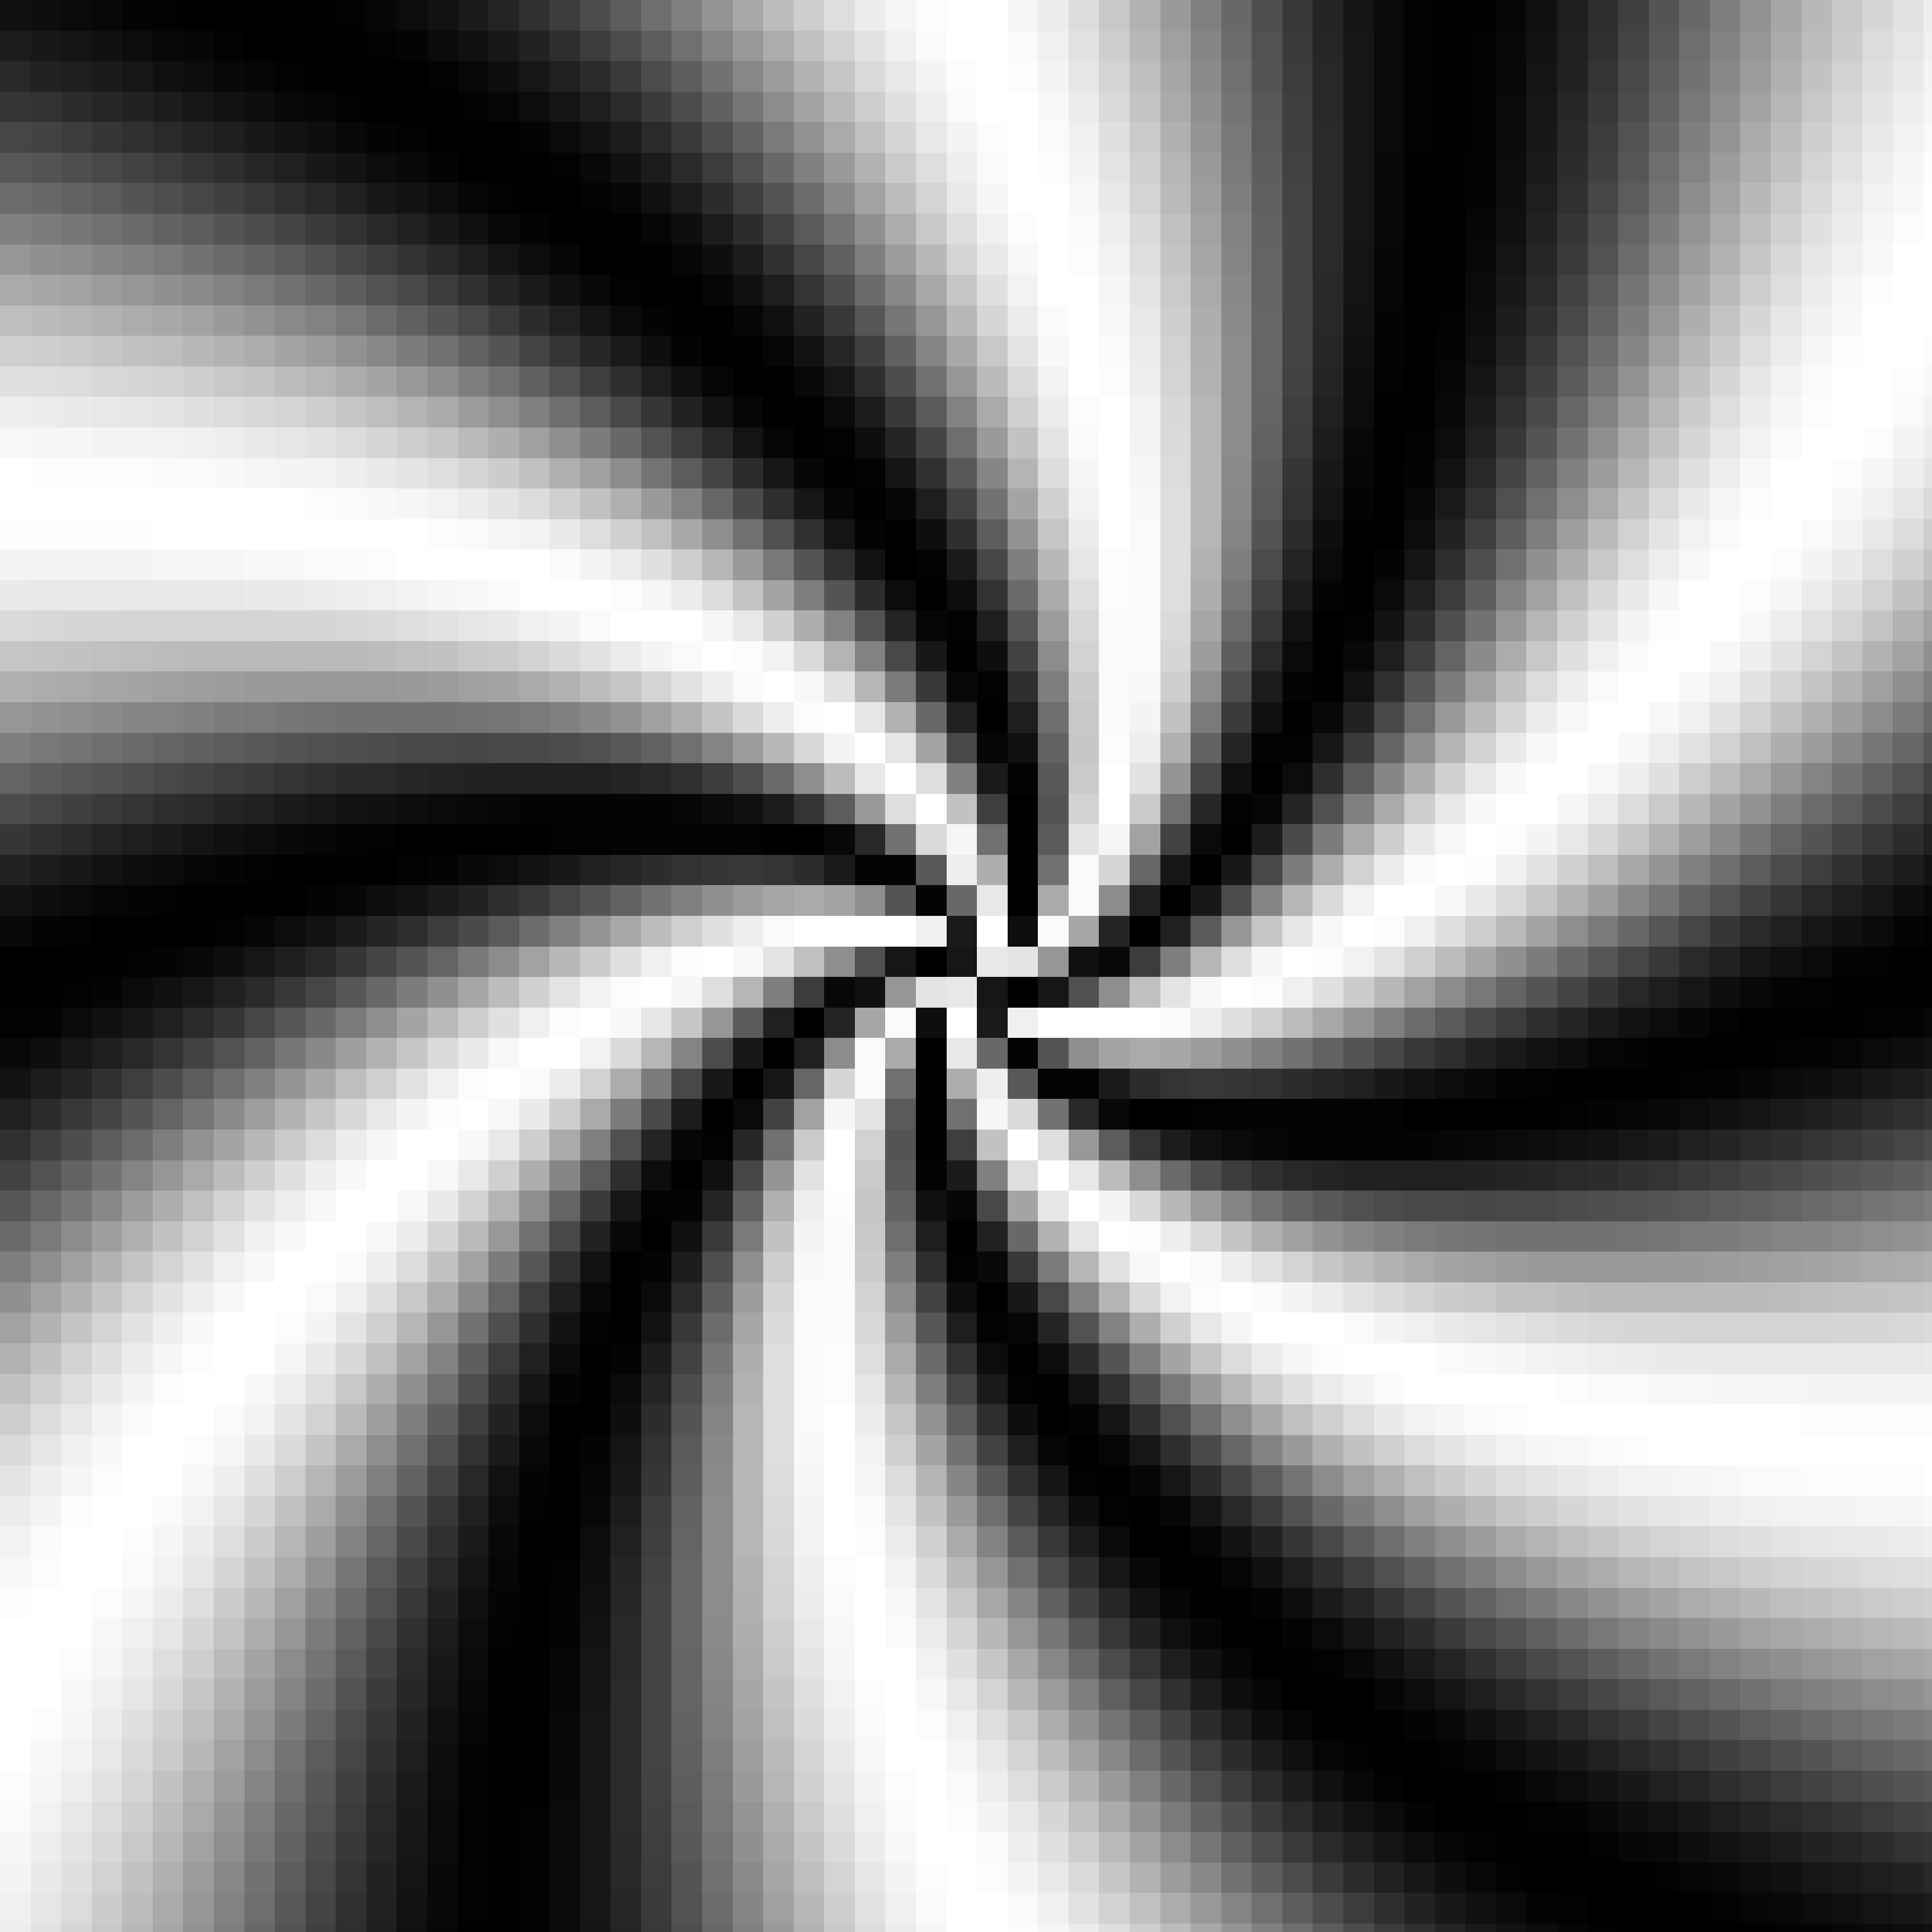
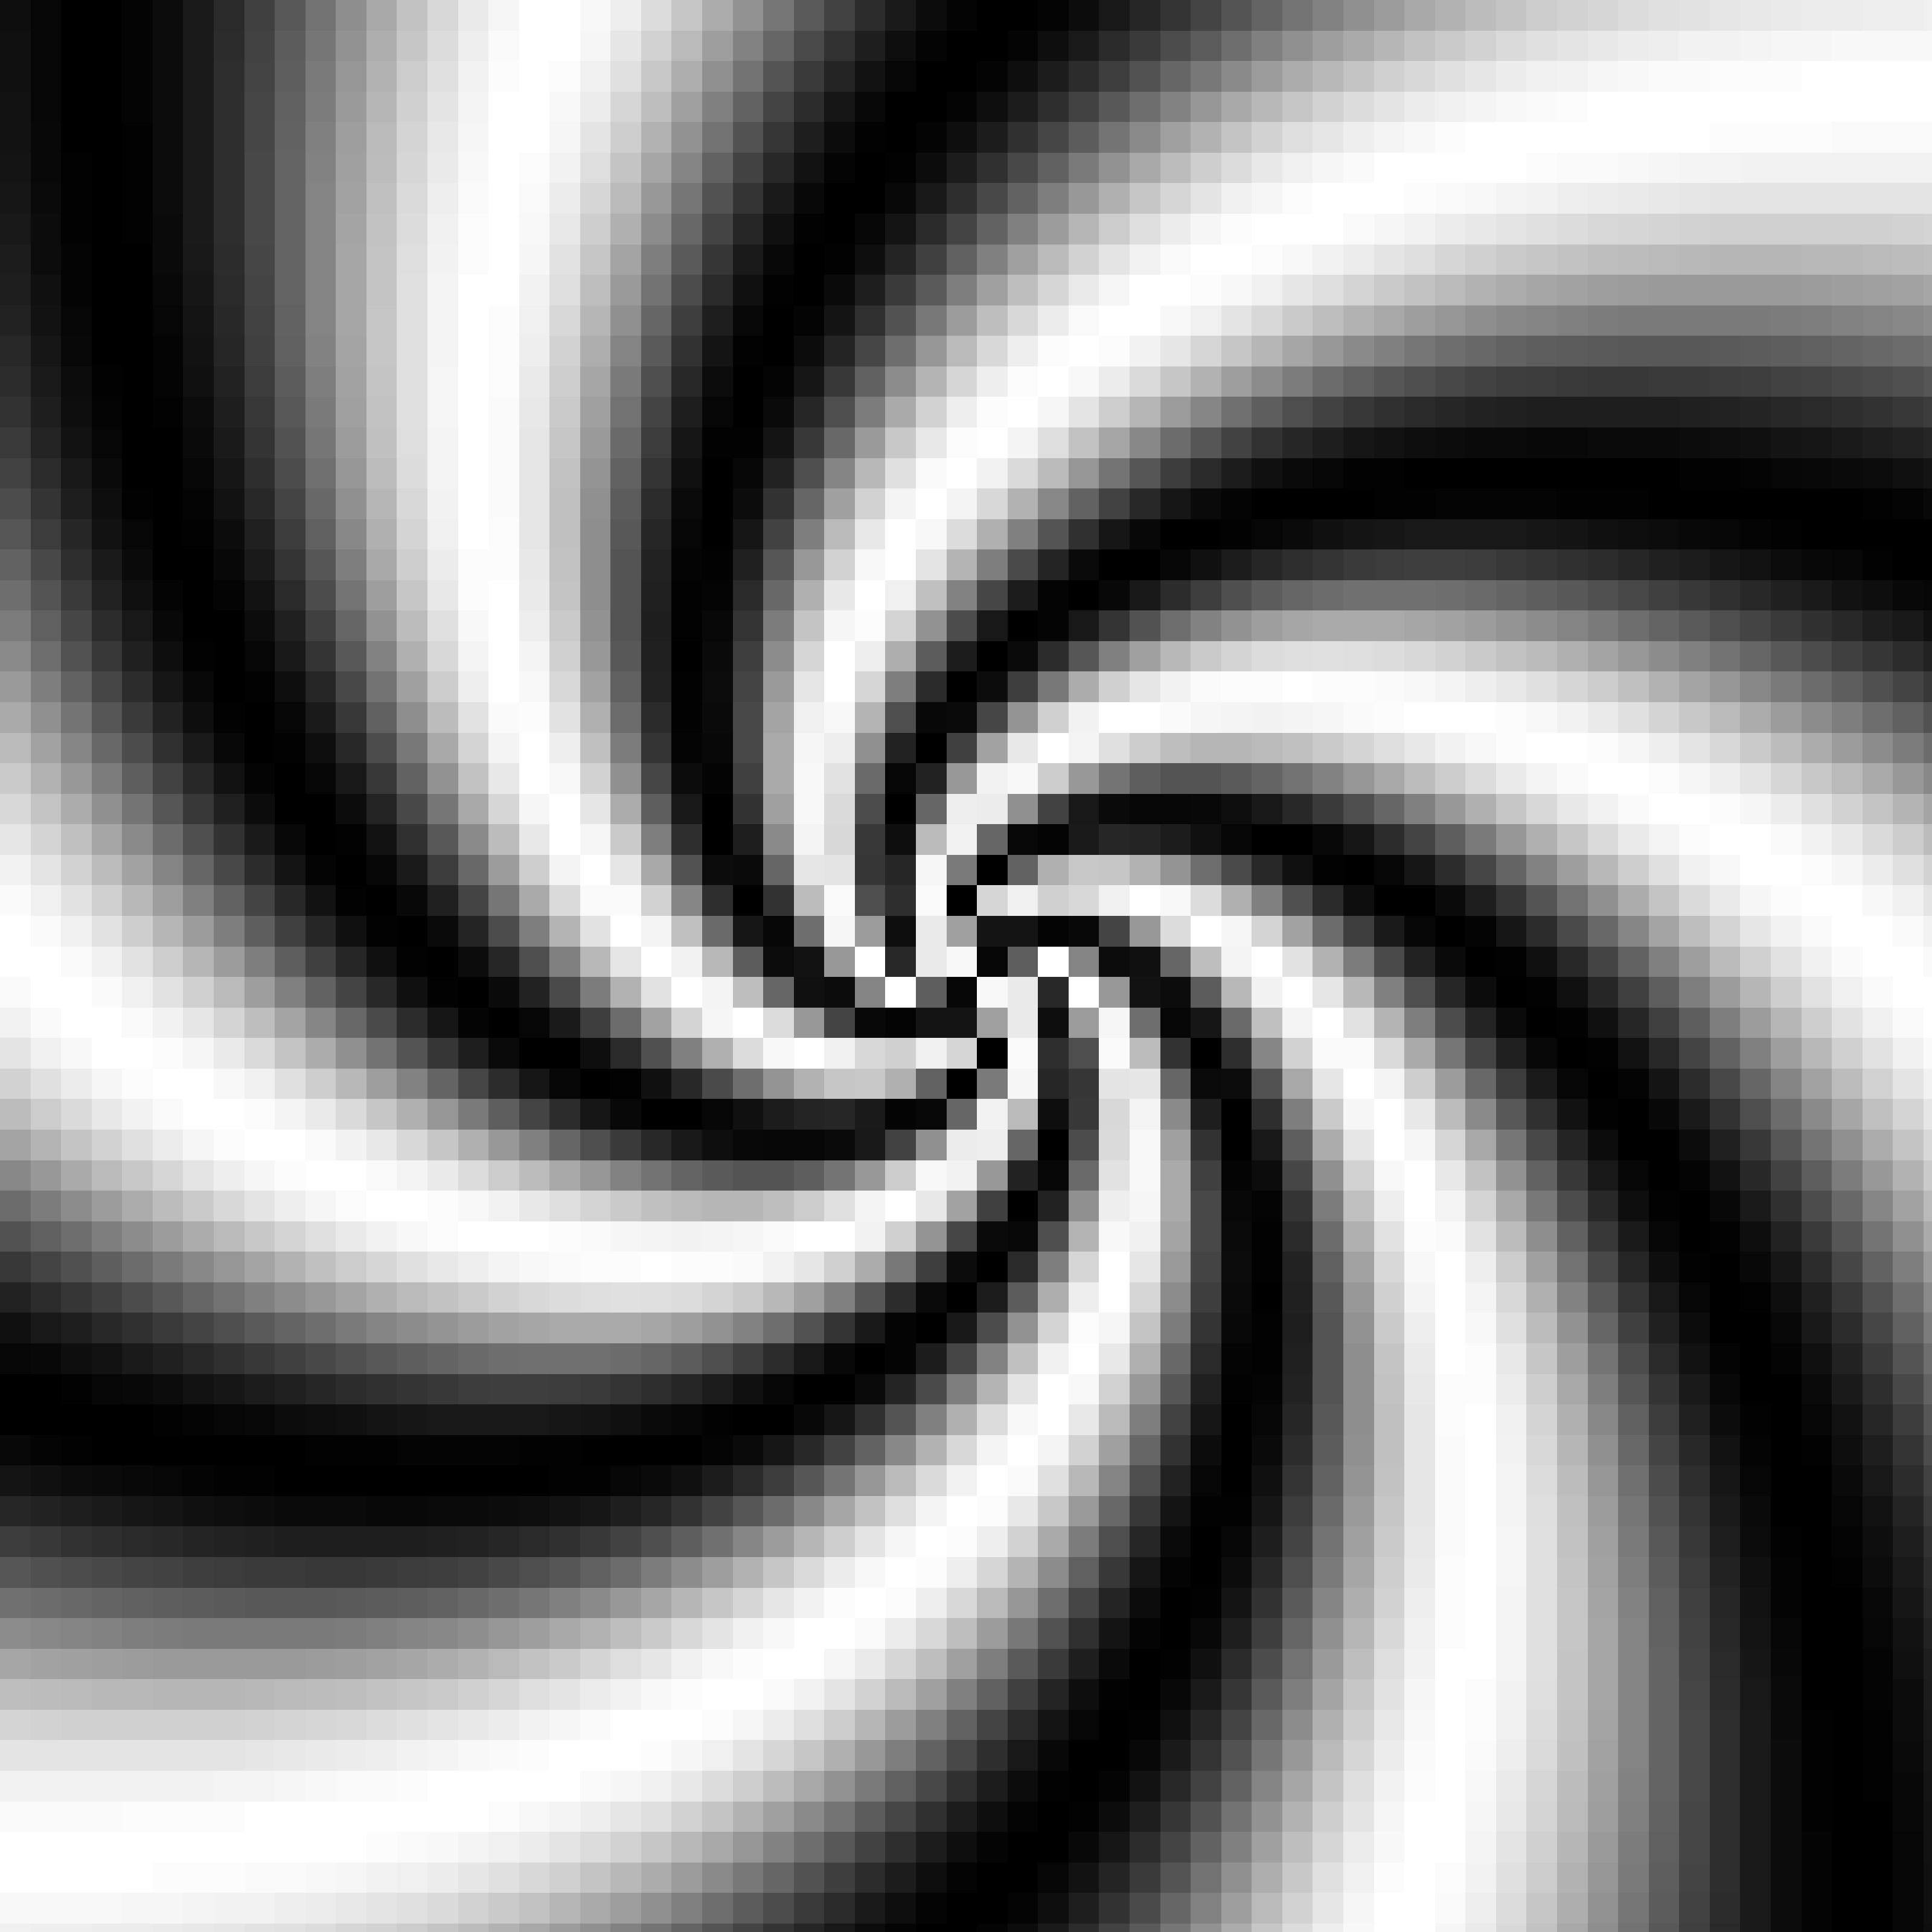
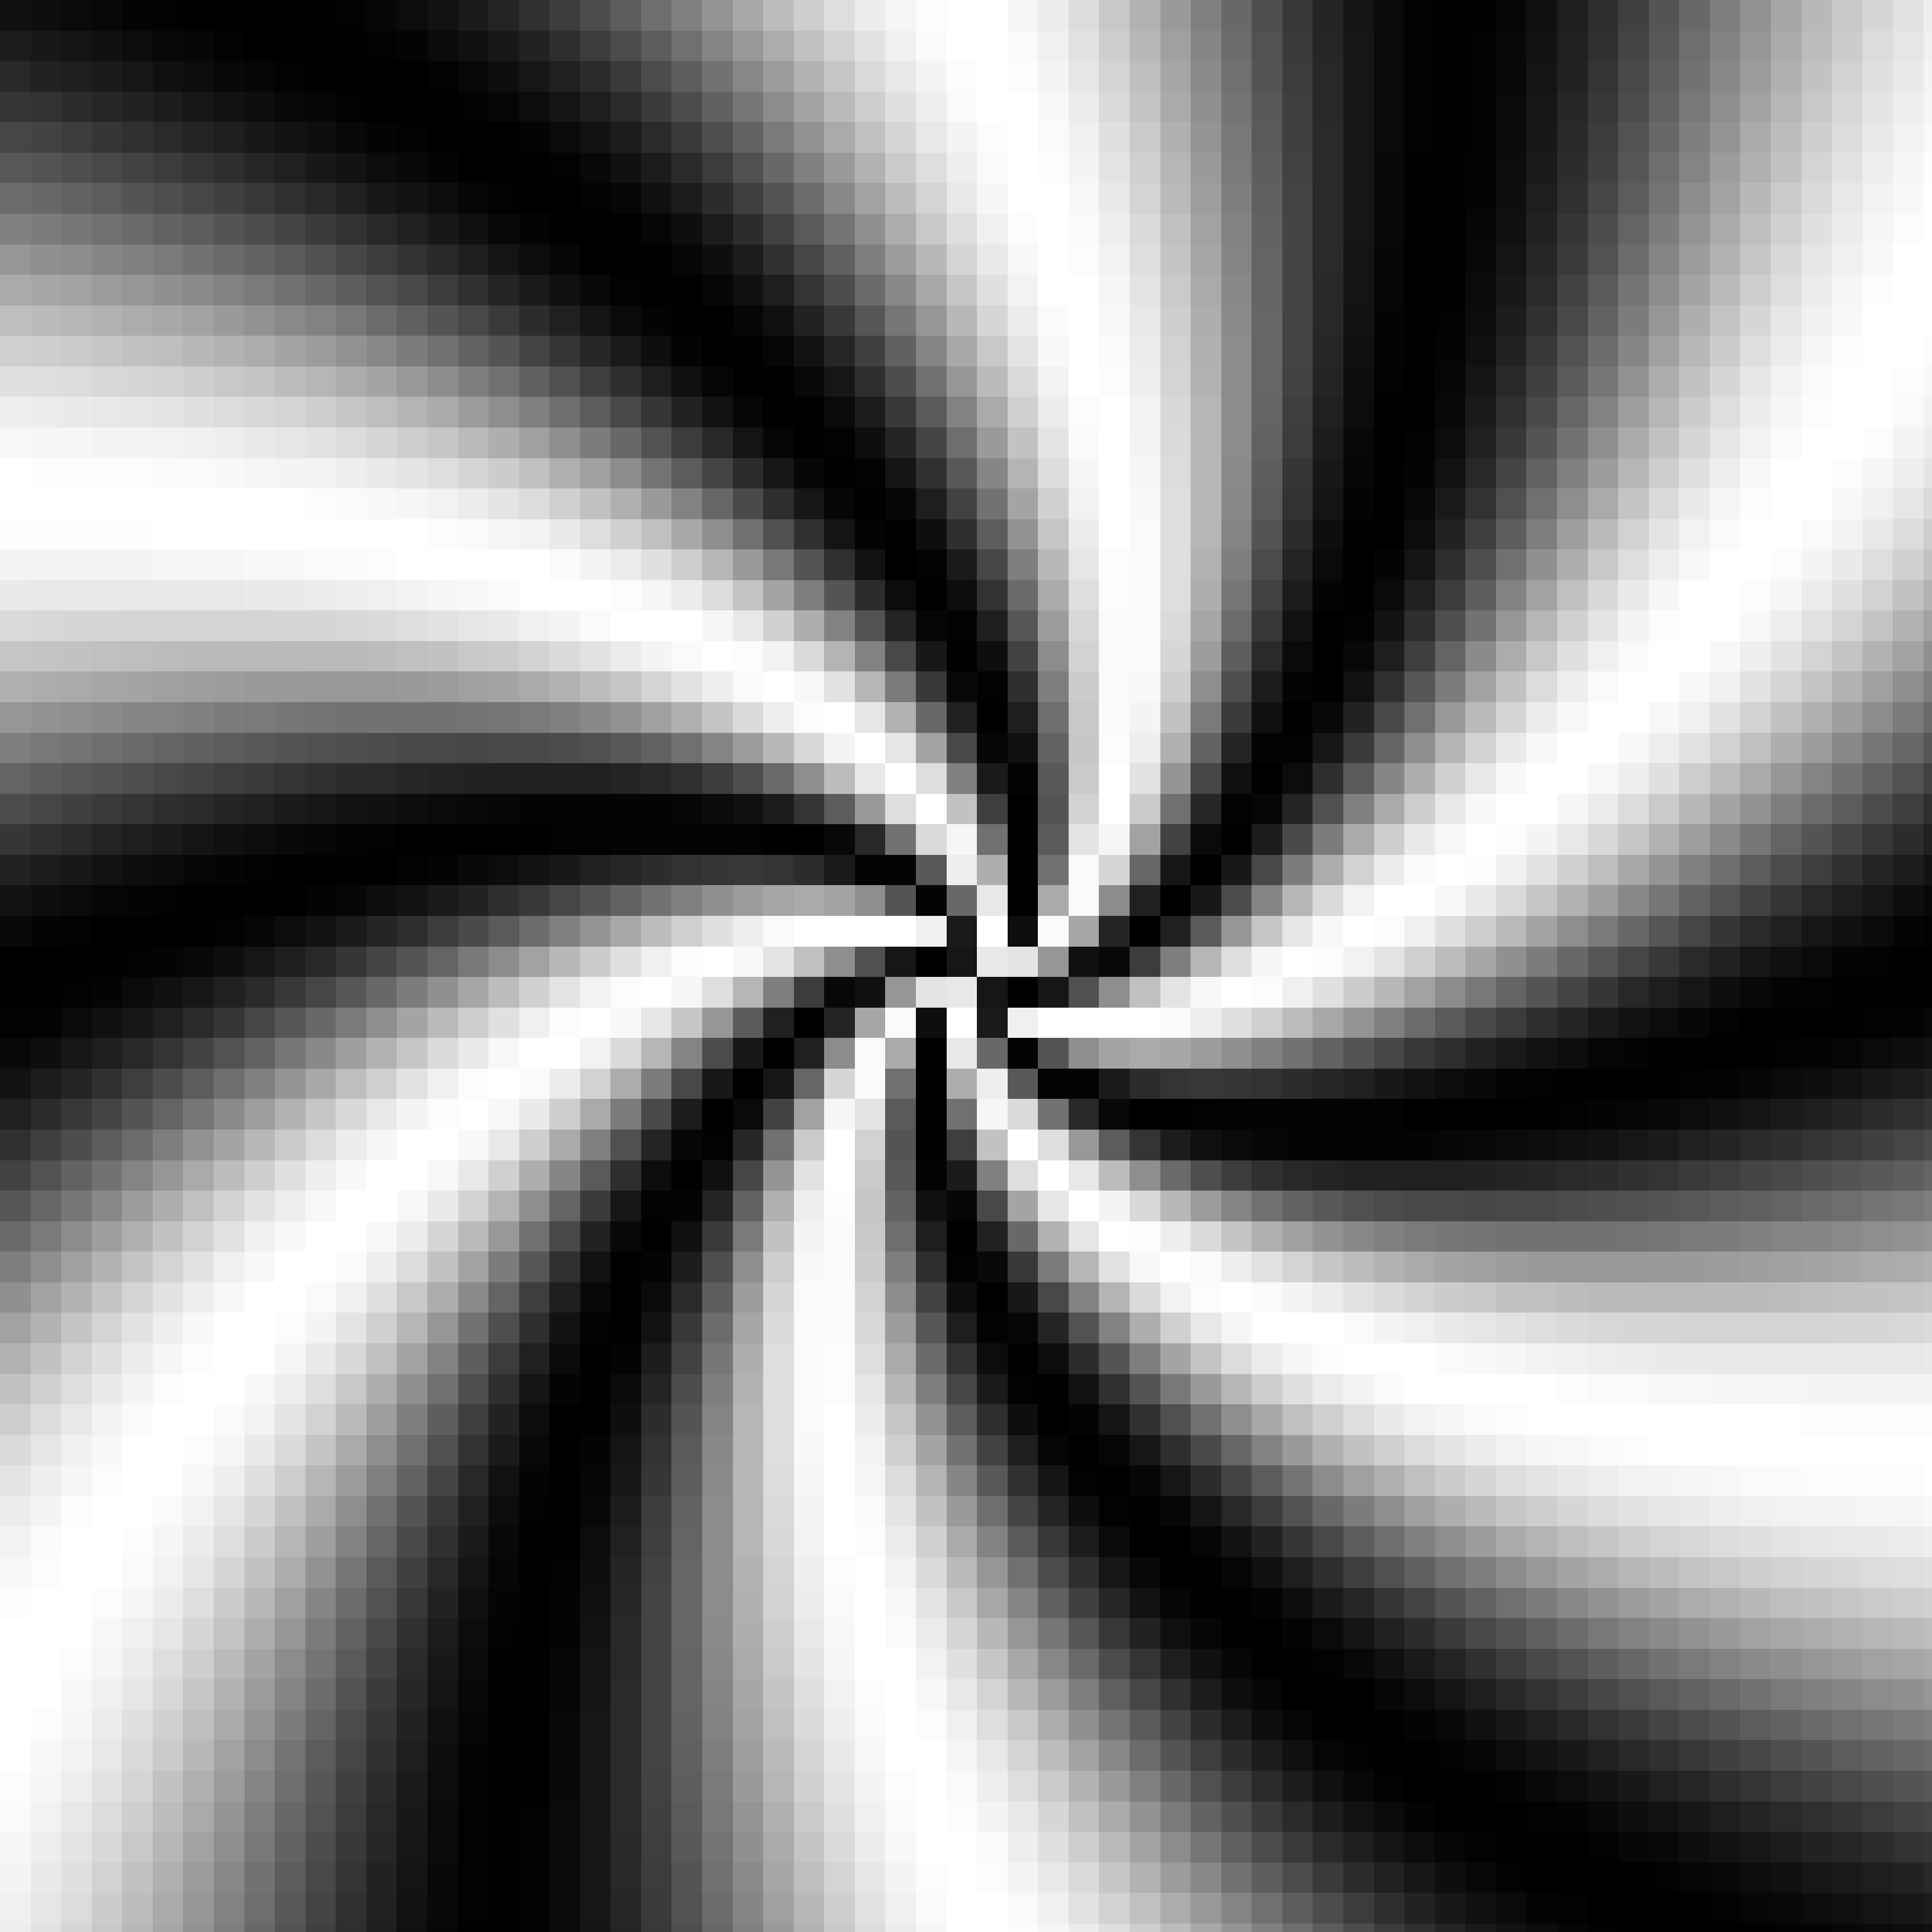
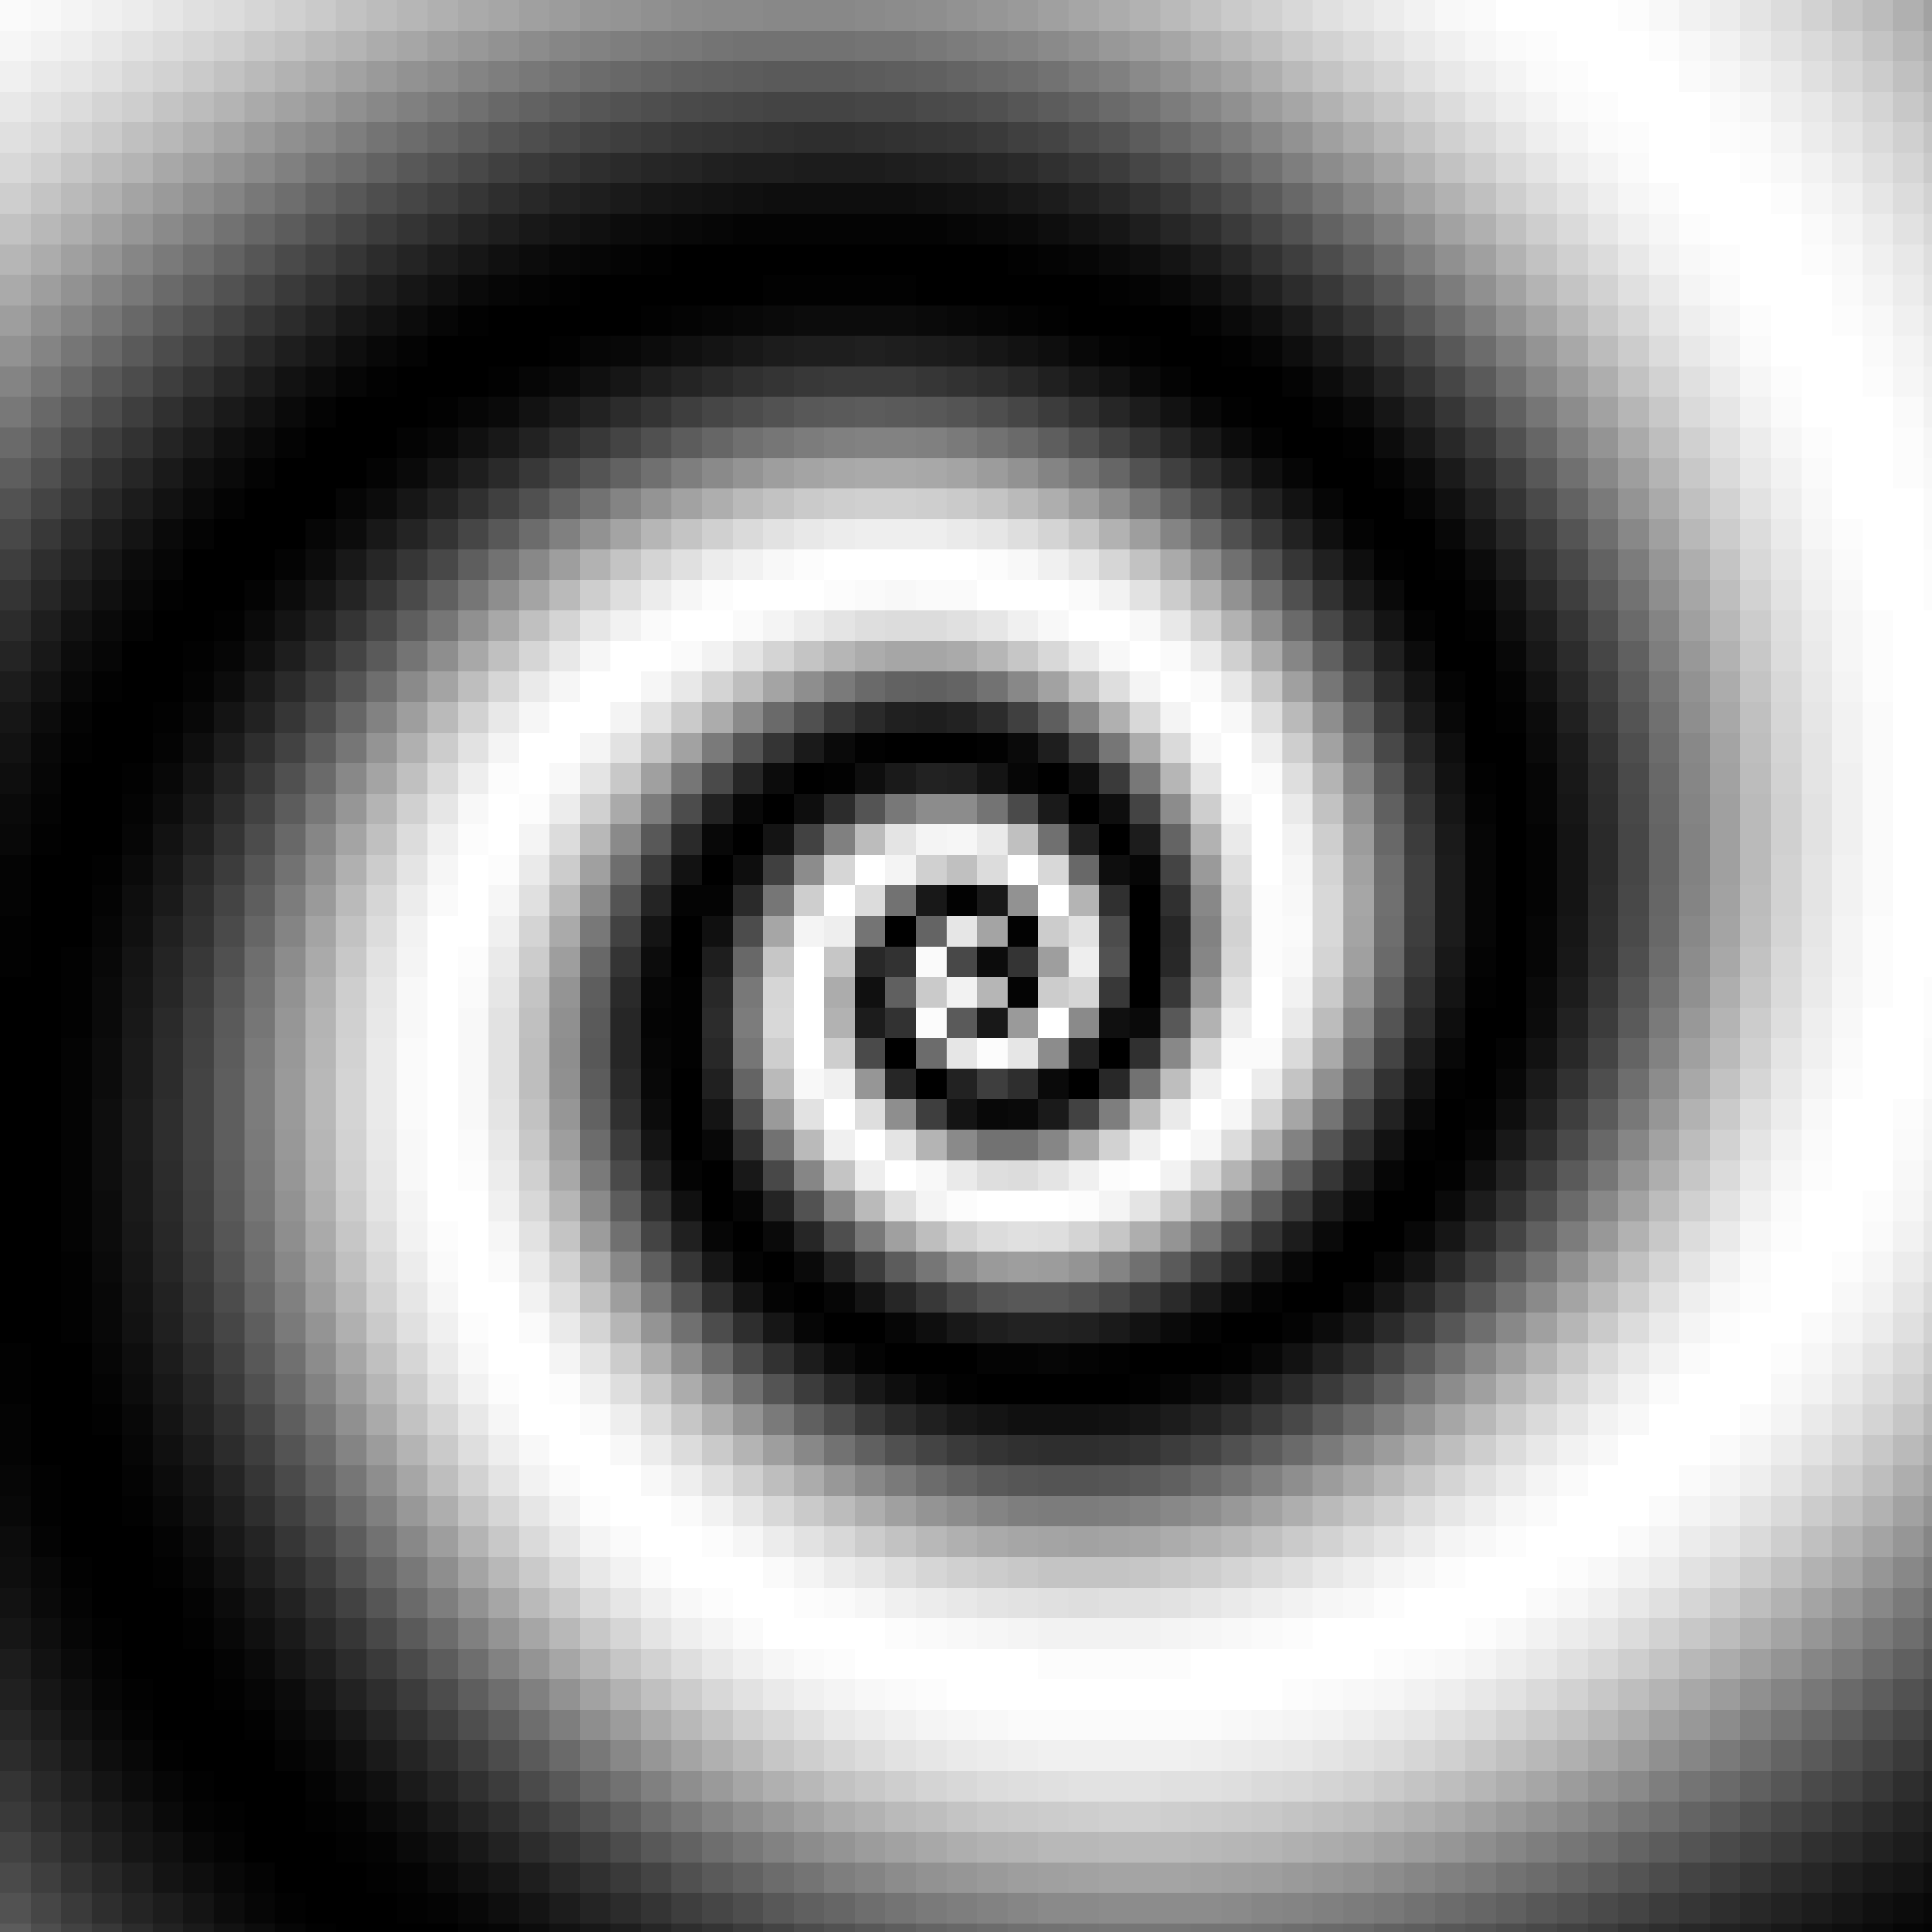
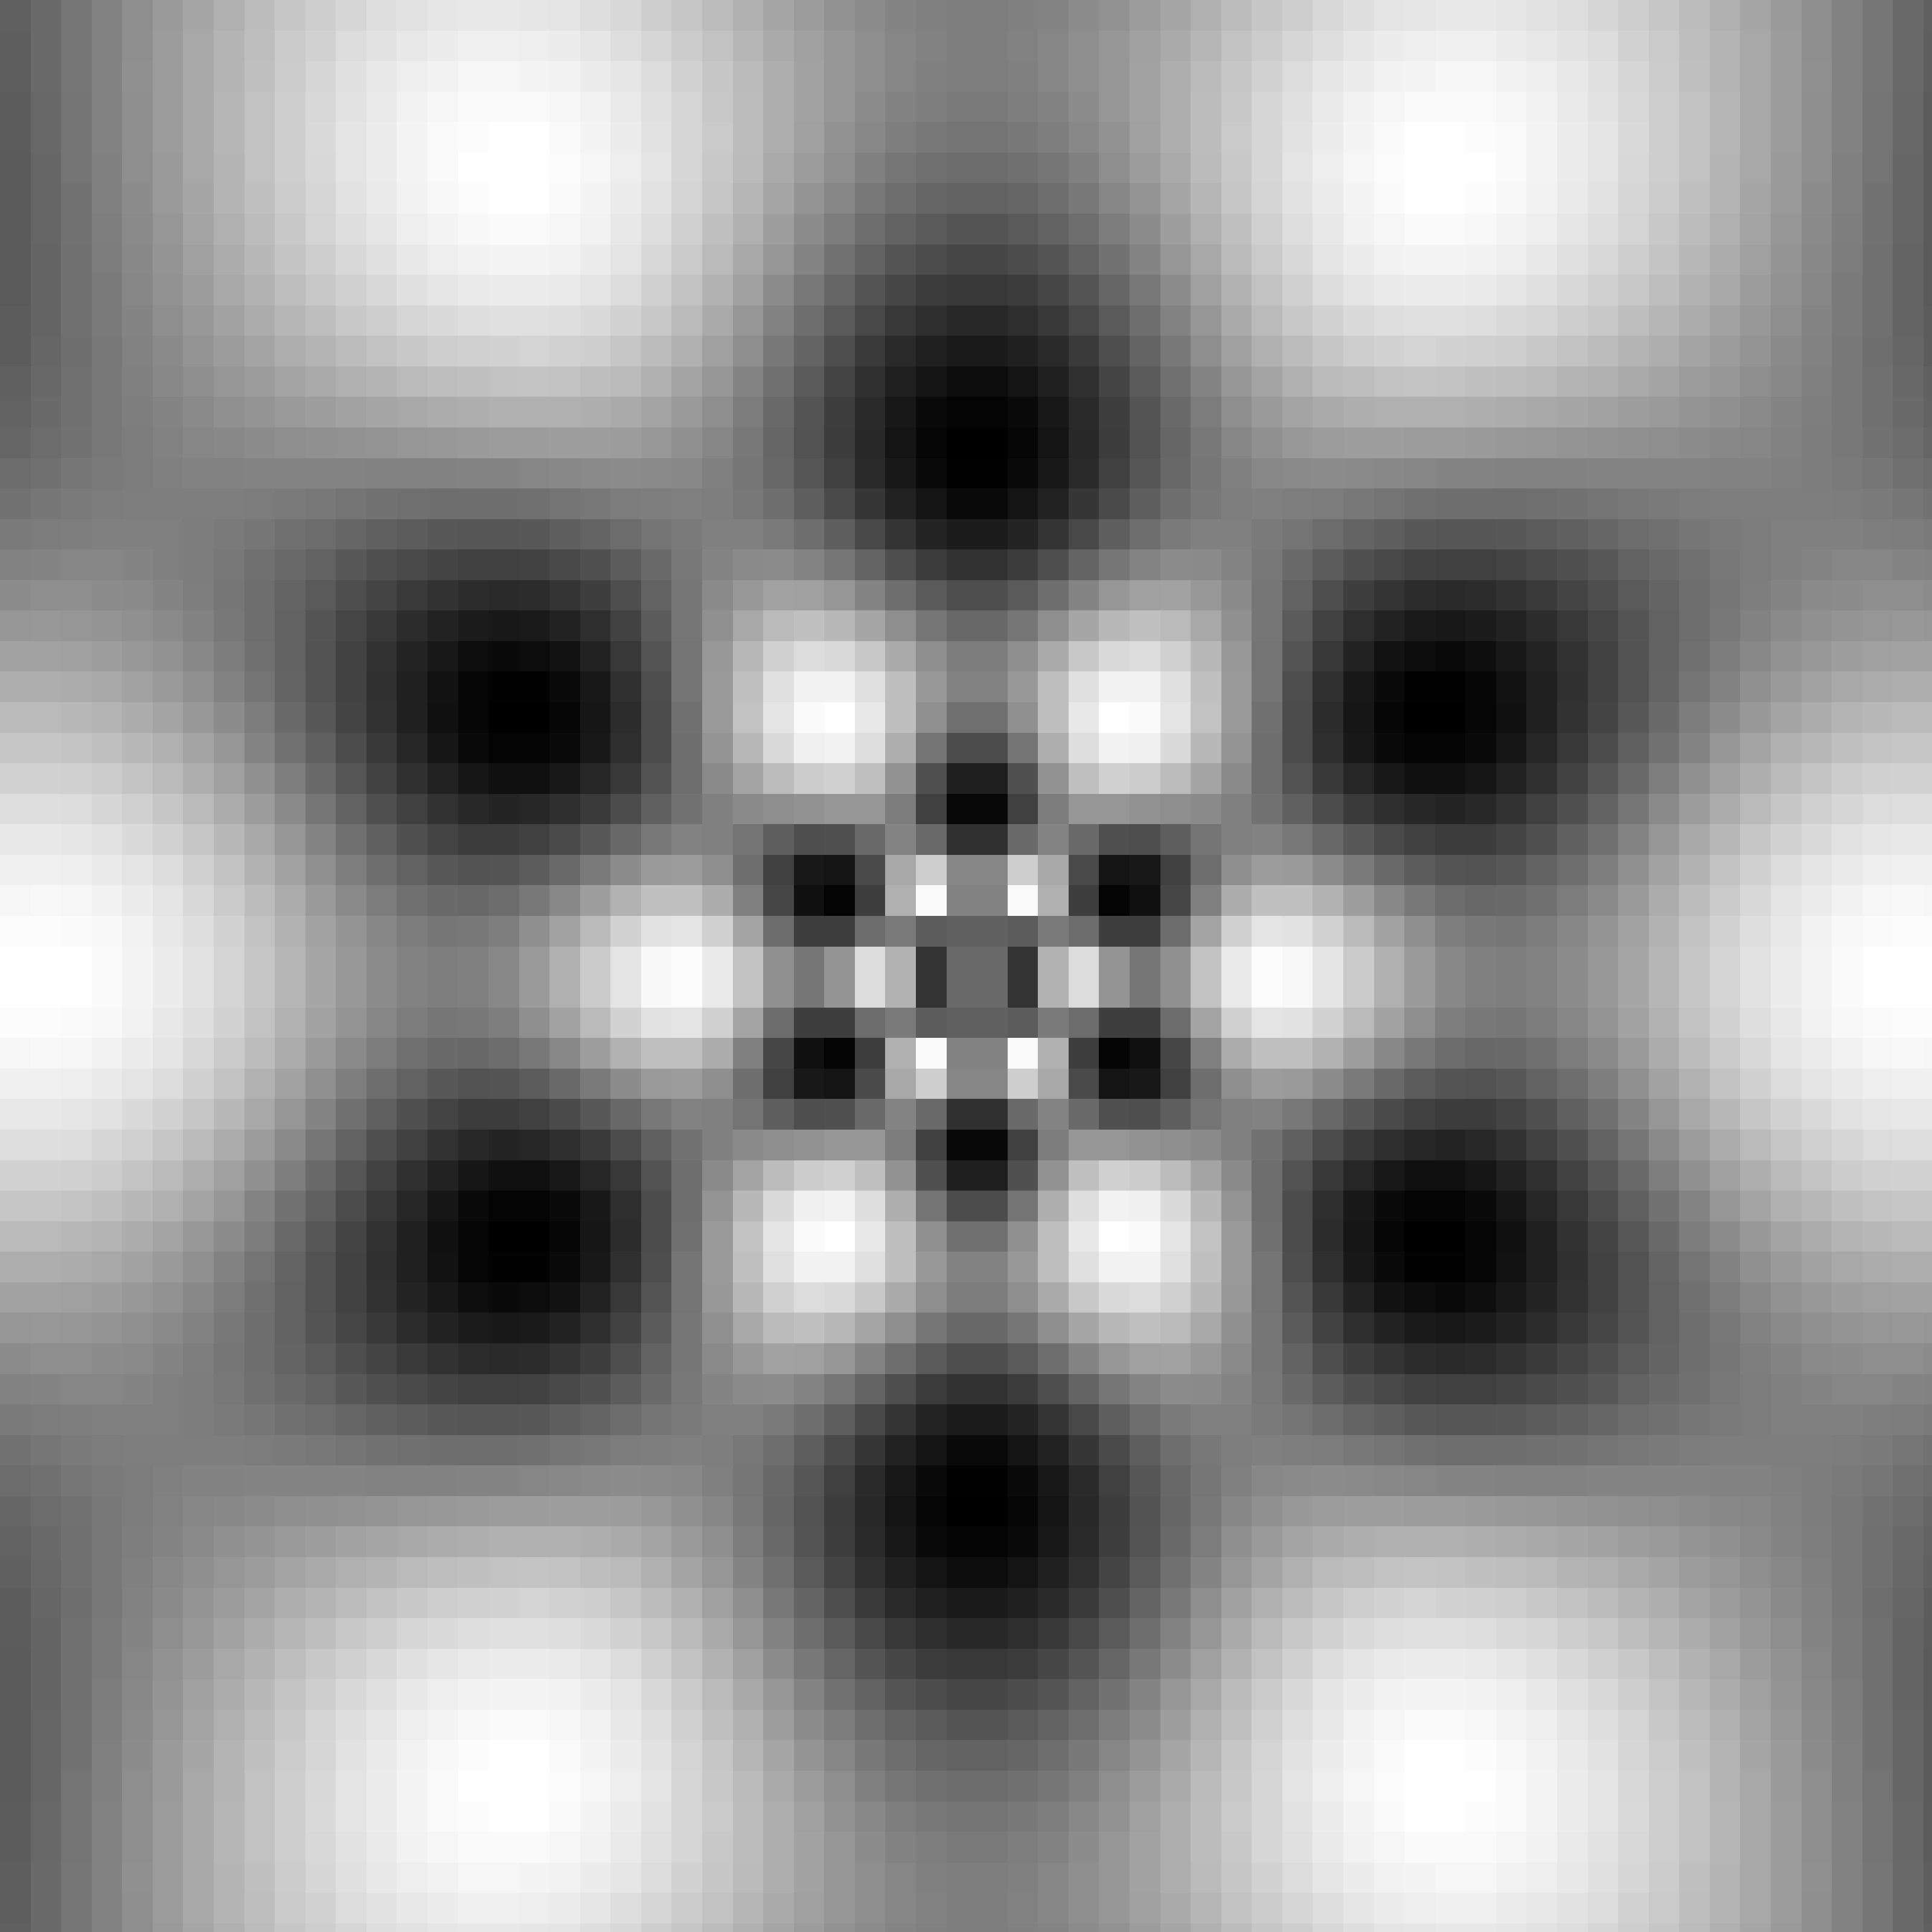

In [33]:
ims = []
freq=6
phase = 0
ampl=1
shape=64
alpha=0
origin = None
ims.append(sfp.stimuli.log_polar_grating(shape, alpha, freq,phi=phase,ampl=ampl, origin=origin))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha, w_a=freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha, freq/2,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,-freq,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,freq/2,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,freq,freq/4,phi=phase,ampl=ampl))
ims.append(ims[0]+ims[1])
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, w_a=freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, check_scale_factor=50, orig_origin=origin))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, check_scale_factor=200, orig_origin=origin))

# Example stimuli
jbh.showIm(ims, ncols=min(len(ims), 4),zoom=50)

In order to investigate this a little more, we create compare the second, radial stimulus with a more heavily-sampled version.

The first plot shows the central slice of the 64 x 64 image in green and the central slice of the grating 99 times larger in blue. We clearly see some very high frequency signal that is being missed.

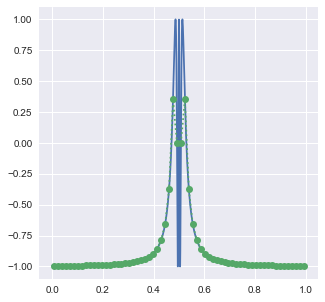

In [7]:
stim, over_sampled_stim = sfp.stimuli.check_aliasing(64, 0, w_a=6, )

This second plot shows the two images, and again we can see the aliasing at the center


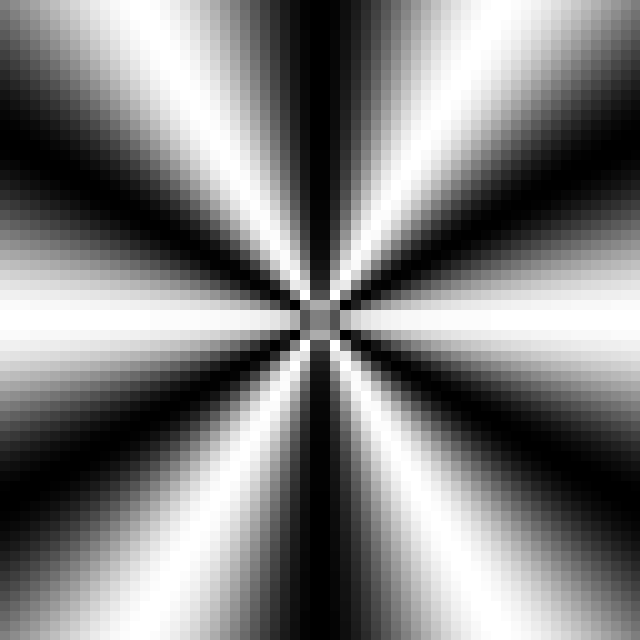
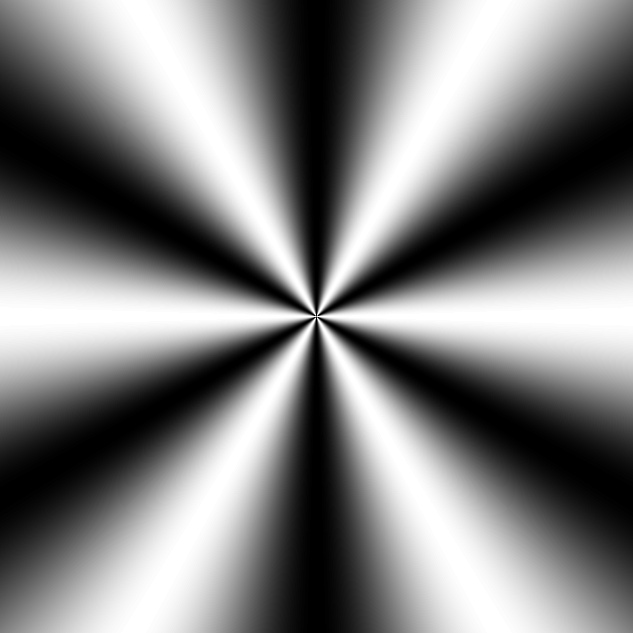

In [8]:
jbh.showIm([stim, over_sampled_stim], ncols=2, zoom=[10, .1])

To deal with this issue, we create a mask that we'll lay at the center of the image, completely masking out the aliased portion of the stimuli and then fading gradually to invisible as we move away from it.

This first plot shows the same slice as above for the un-masked, fade-masked, and binary-masked stimuli.

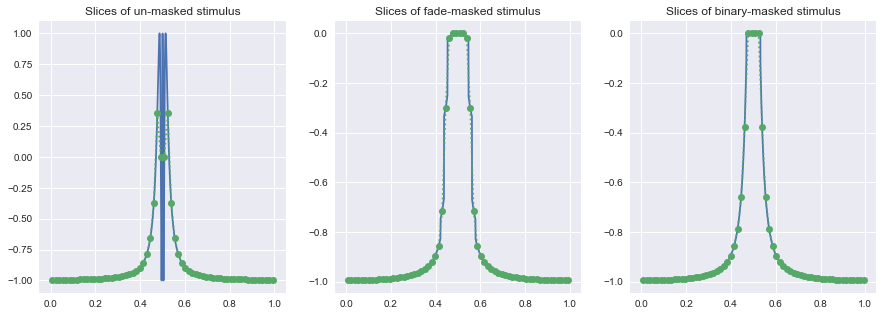

In [9]:
tmps = sfp.stimuli.check_aliasing_with_mask(64, 0, w_a=6, )

This here shows the 64 x 64 image with no mask, the faded mask, and the binary mask. We can see that the masking hides the aliased portion of the image.


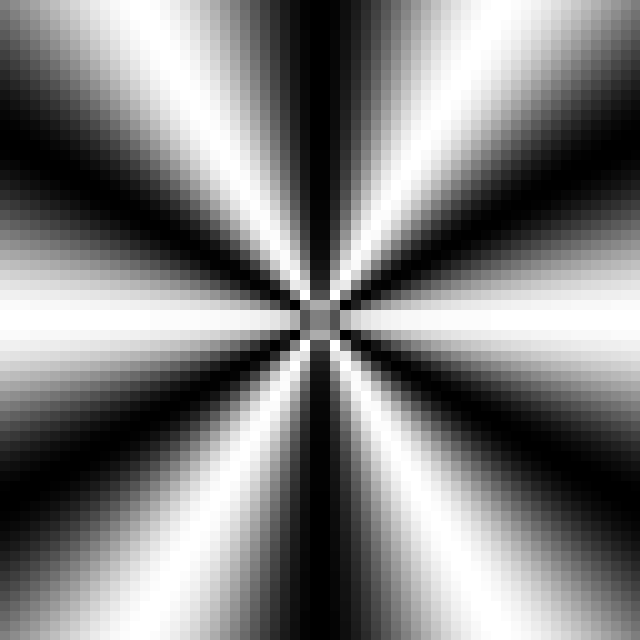
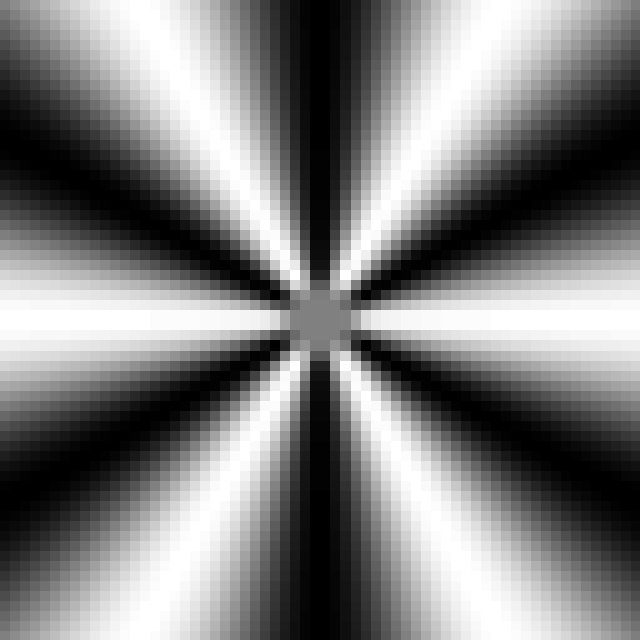
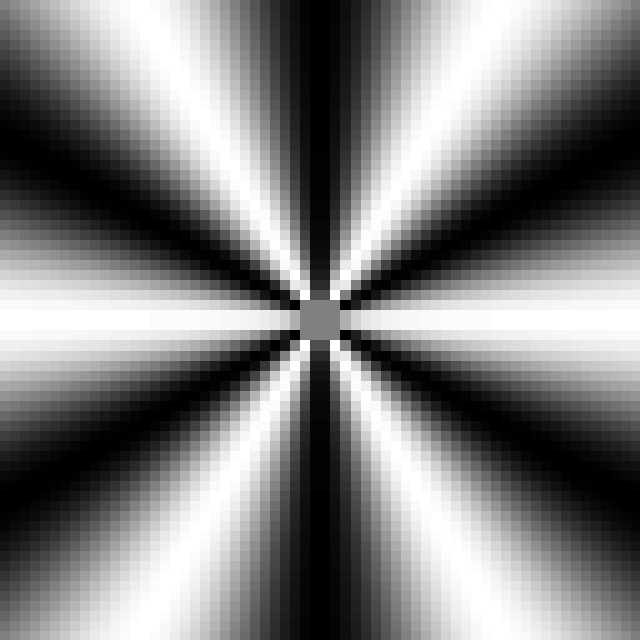

In [10]:
jbh.showIm([tmps[0], tmps[1] * tmps[0], tmps[2] * tmps[0]],# tmps[3], tmps[4]* tmps[3], tmps[5]*tmps[3]], 
           ncols=3, zoom=[10,10,10,.1,.1,.1])

Now that we know the stimuli we want to create and are convinced that masking takes care of their aliasing, we create all the stimuli for experiment. We do this using the `main` function, which requires that the `size`, `origin`, and `number_of_fade_pixels` parameters be constant across all stimuli, but allows the others to vary. We create all the stimuli and then apply the largest mask to them, so that all stimuli have the same mask and none show any aliasing. The function returns both the unmasked (`stim`) and masked (`mstim`) versions of the stimuli, but we only want the masked versions (the unmasked are only returned so they can be double-checked.


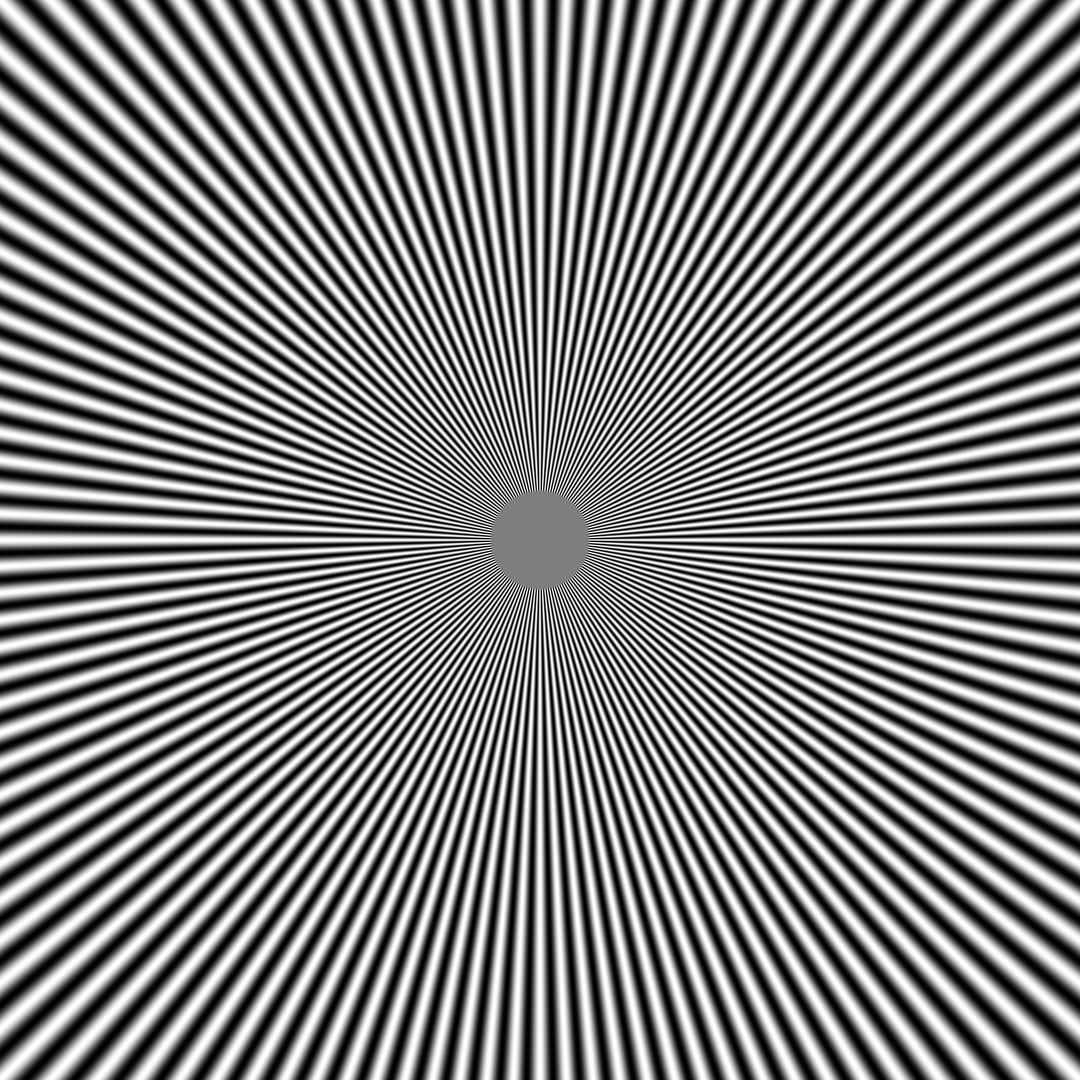

In [5]:
mstim, stim = sfp.stimuli.gen_stim_set(1080, 4, (0, 128))# phi=np.array(range(10))/10.*2*np.pi, )

#jbh.showIm(stim, ncols=4, zoom=5)
jbh.showIm(mstim, ncols=4, )#zoom=5)


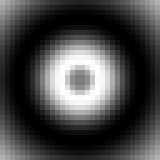
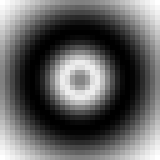
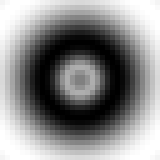
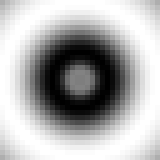
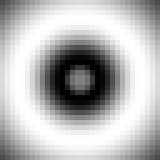
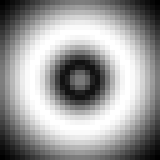
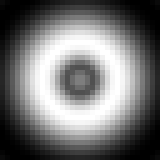
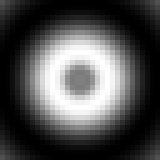
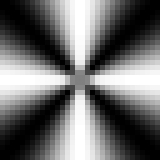
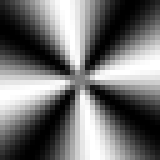
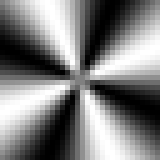
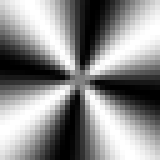
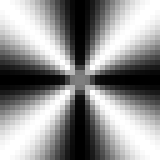
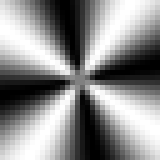
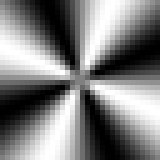
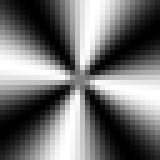
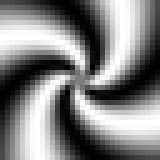
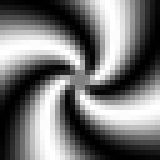
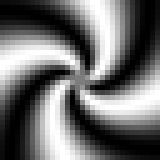
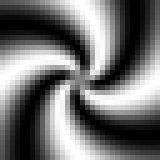
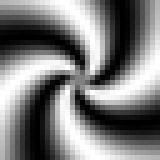
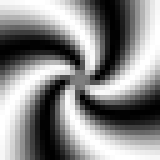
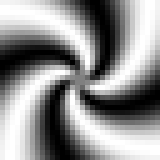
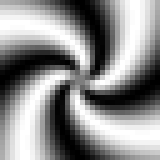

In [2]:
mstim, stim = sfp.stimuli.gen_stim_set(32, 4, freqs_ra=[(4,0),(0,4),(4,4)], phi=np.array(range(8))/8.*2*np.pi, )

#jbh.showIm(stim, ncols=4, zoom=5)
jbh.showIm(mstim, ncols=6, zoom=5)

# Stimulus properties

For the purposes of creating our stimuli, we're interested in a couple of numbers that aren't apparent from the plots above:

 - how big the anti-aliasing mask in the center will be
 - what the minimum spatial frequency in the stimulus will be
 - what the maximum spatial frequency (after applying the mask) will be

for the spatial frequencies, we're interested in this in units of cycles per visual degree, so we create the full-size stimulus (1080 x 1080 pixels) and input the diameter of the stimulus in visual degrees (28).

In [6]:
mask_df = sfp.stimuli.check_stim_properties(1080, None, 28, w_r=[0, 128], w_a=[0, 128], alpha=[0, 4])

/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


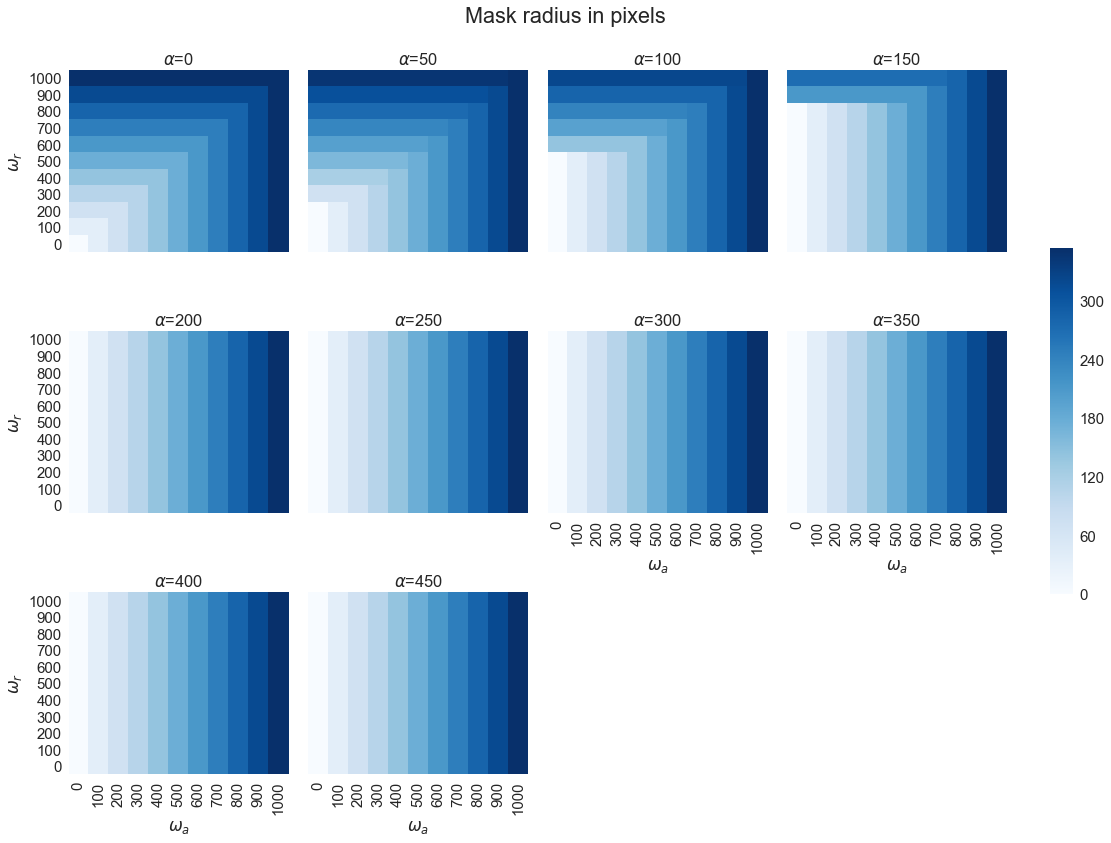

In [3]:
sfp.stimuli.plot_stim_properties(mask_df, size=4)

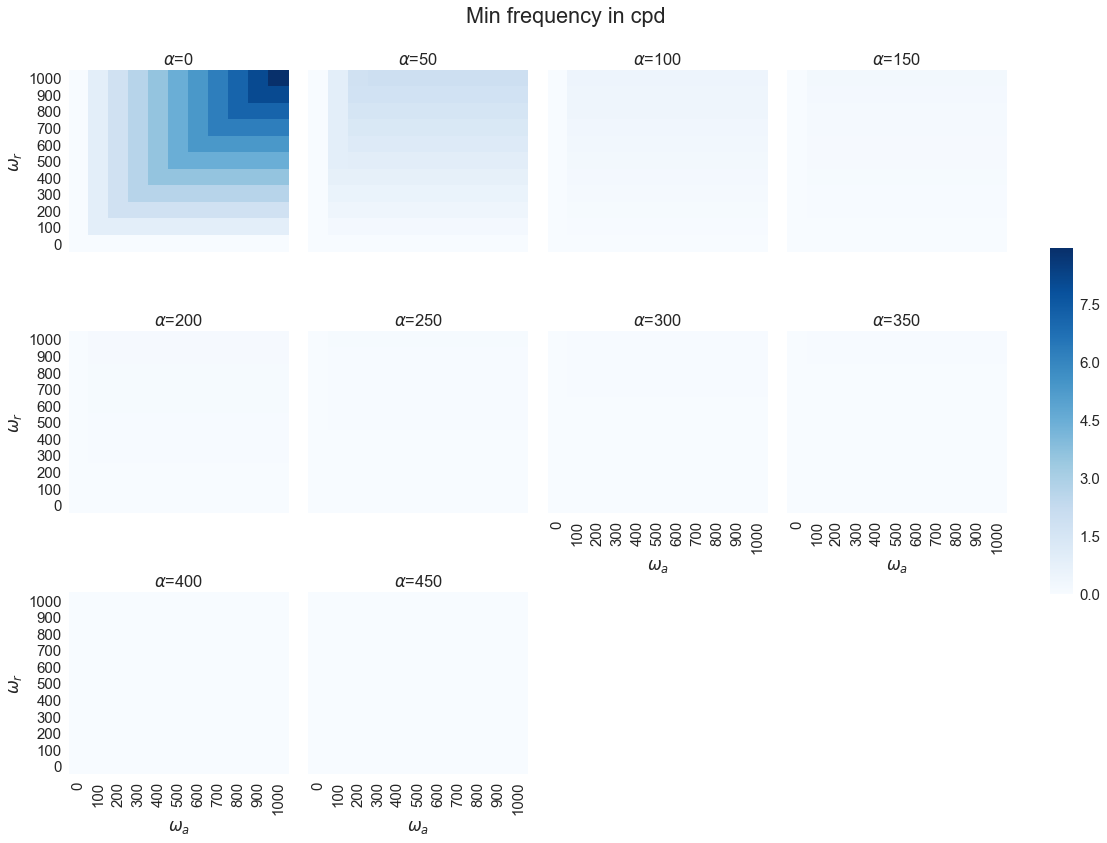

In [4]:
sfp.stimuli.plot_stim_properties(mask_df, data_label='cpd_min', title_text="Min frequency in cpd", size=4)

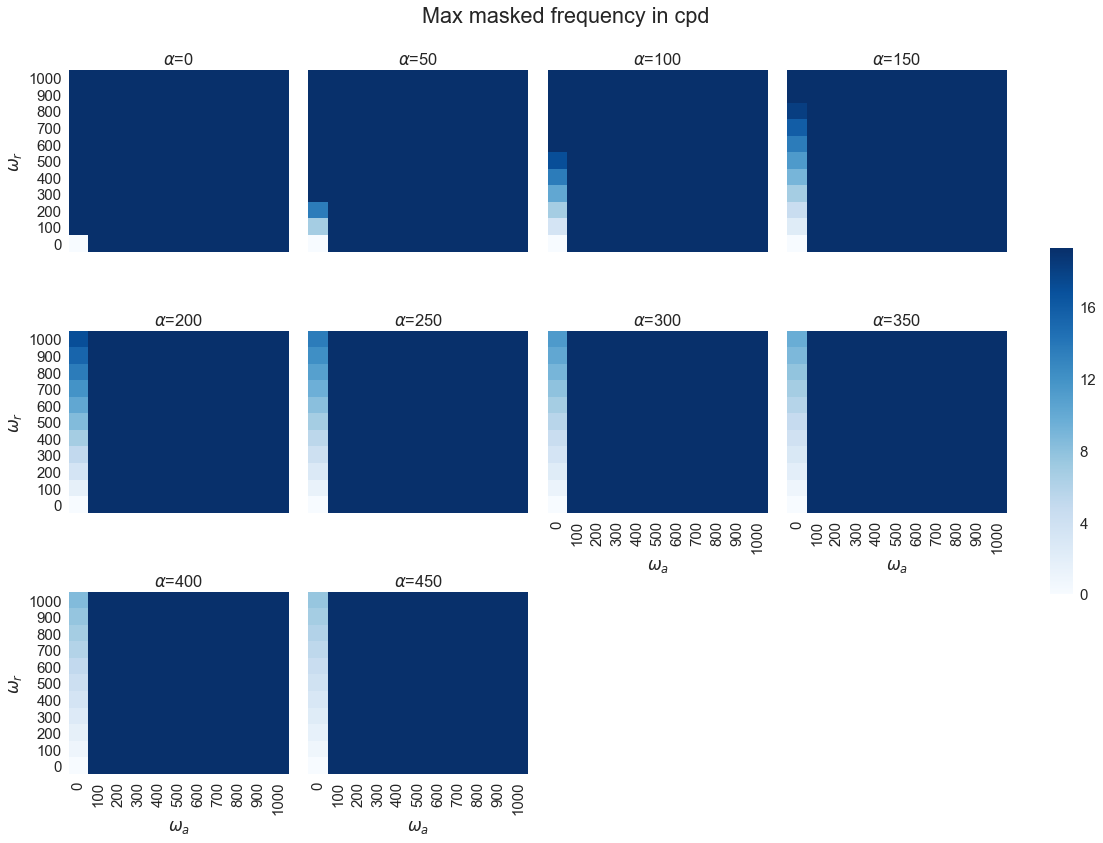

In [5]:
sfp.stimuli.plot_stim_properties(mask_df, data_label='cpd_masked_max', title_text="Max masked frequency in cpd", size=4)

# Noise stimuli

/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars



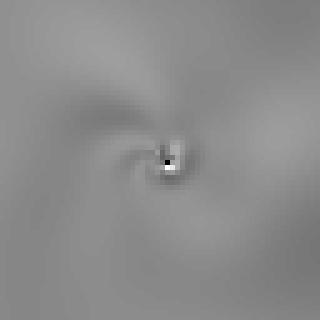

In [120]:
# should these be random samples or a more systematic searching of the space?
radius = 5
bandwidth = 1
samples = 1000
angle_upper_lim = np.pi/2
noise = []
freqs = []
for i in range(samples):
#     dist = np.random.uniform(radius-bandwidth, radius+bandwidth)
    dist = np.random.normal(radius, bandwidth)
    ang = np.random.uniform(0, angle_upper_lim)
    # making them integer avoids the "break" at angle=0
    w_a = np.round(dist * np.sin(ang))
    w_r = np.round(dist * np.cos(ang))
    # dist and ang technically aren't the correct values for dist and ang, since I rounded w_a and w_r
    rounded_ang = np.arctan(w_a/w_r)
    if rounded_ang != 0:
        rounded_dist = w_a / np.sin(rounded_ang)
    else:
        rounded_dist = w_r / np.cos(rounded_ang)
    freqs.append((w_a, w_r, dist, ang, rounded_dist, rounded_ang))
    noise.append(sfp.stimuli.log_polar_grating(64, 0, w_r, w_a, np.random.uniform(0, np.pi)))
noise.append(np.array(noise).mean(0))

jbh.showIm(noise[-1], zoom=5, ncols=5)

In [121]:
polar_angle_pi_incr = 4

freqs = pd.DataFrame(freqs, columns=['w_a', 'w_r', 'radius', 'polar_angle', 'rounded_radius', 'rounded_angle'])

# we just need to pick an arbitrary column for the value here, since we're counting
freq_hm = freqs.pivot_table('radius', index='w_a', columns='w_r', aggfunc='count', fill_value=0, dropna=False)
polar_hm = freqs.pivot_table('radius', index='rounded_radius', columns='rounded_angle', aggfunc='count', fill_value=0, dropna=False)

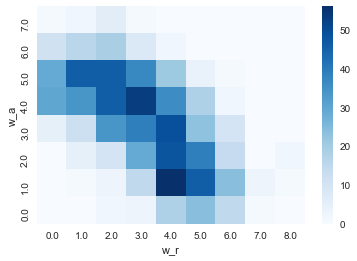

In [122]:
# jointplot not appropriate for this, because the data is inherently discrete
sns.heatmap(freq_hm, cmap='Blues').invert_yaxis()

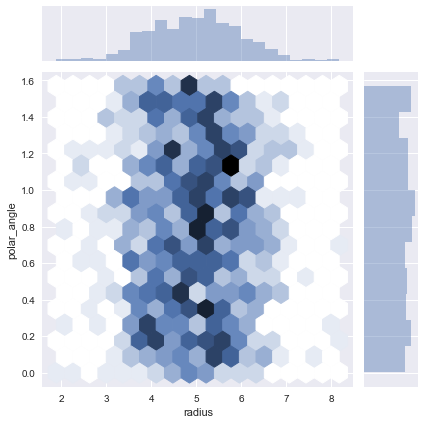

In [123]:
sns.jointplot('radius', 'polar_angle', freqs, 'hex', stat_func=None, )

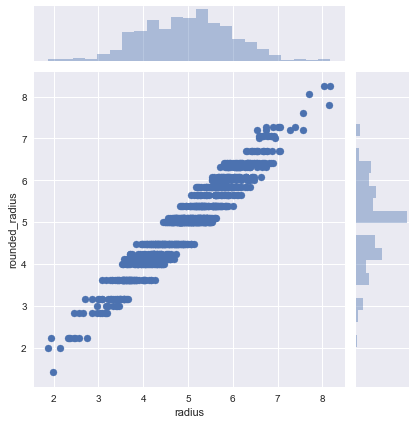

In [124]:
sns.jointplot('radius', 'rounded_radius', freqs, 'scatter', stat_func=None, )

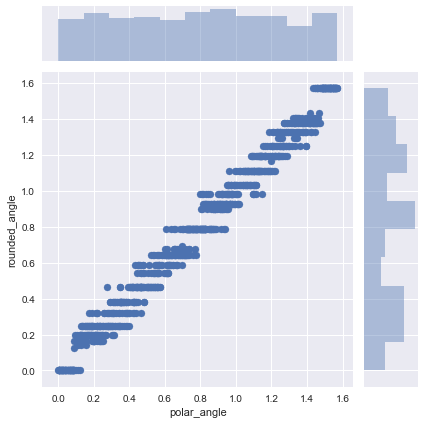

In [125]:
sns.jointplot('polar_angle', 'rounded_angle', freqs, 'scatter', stat_func=None, )

# Psychopy


In [16]:
win, keys, fix = sfp.experiment.run("../data/stimuli/run00.npy", session_length=20, fixation_type='digit')

406.0271 	WARNING 	Requested an unavailable screen number - using first available.
406.0274 	WARNING 	User requested fullscreen with size [1080 1080], but screen is actually [1920, 1200]. Using actual size
407.9294 	WARNING 	t of last frame was 94.17ms (=1/10)
408.0185 	WARNING 	t of last frame was 89.12ms (=1/11)
408.1082 	WARNING 	t of last frame was 89.69ms (=1/11)
408.1952 	WARNING 	t of last frame was 87.06ms (=1/11)
408.2817 	WARNING 	Multiple dropped frames have occurred - I'll stop bothering you about them!


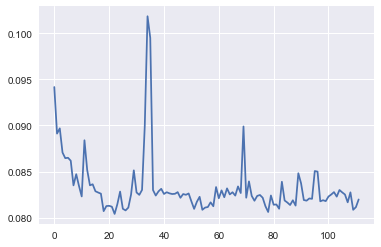

In [17]:
sns.plt.plot(win.frameIntervals)

In [2]:
sfp.experiment.expt(['../data/stimuli/run00.npy', '../data/stimuli/test.npy'], 'test')

1835.5808 	WARNING 	Requested an unavailable screen number - using first available.
1835.5813 	WARNING 	User requested fullscreen with size [1080 1080], but screen is actually [1920, 1200]. Using actual size
1844.7509 	WARNING 	t of last frame was 156.77ms (=1/6)
1844.9065 	WARNING 	t of last frame was 155.55ms (=1/6)
1845.0623 	WARNING 	t of last frame was 155.84ms (=1/6)
1845.2222 	WARNING 	t of last frame was 159.84ms (=1/6)
1845.3777 	WARNING 	Multiple dropped frames have occurred - I'll stop bothering you about them!
2096.6249 	WARNING 	Requested an unavailable screen number - using first available.
2096.6252 	WARNING 	User requested fullscreen with size [1080 1080], but screen is actually [1920, 1200]. Using actual size


# Experiment stimuli

In [26]:
stim = sfp.stimuli.main()

KeyboardInterrupt: 


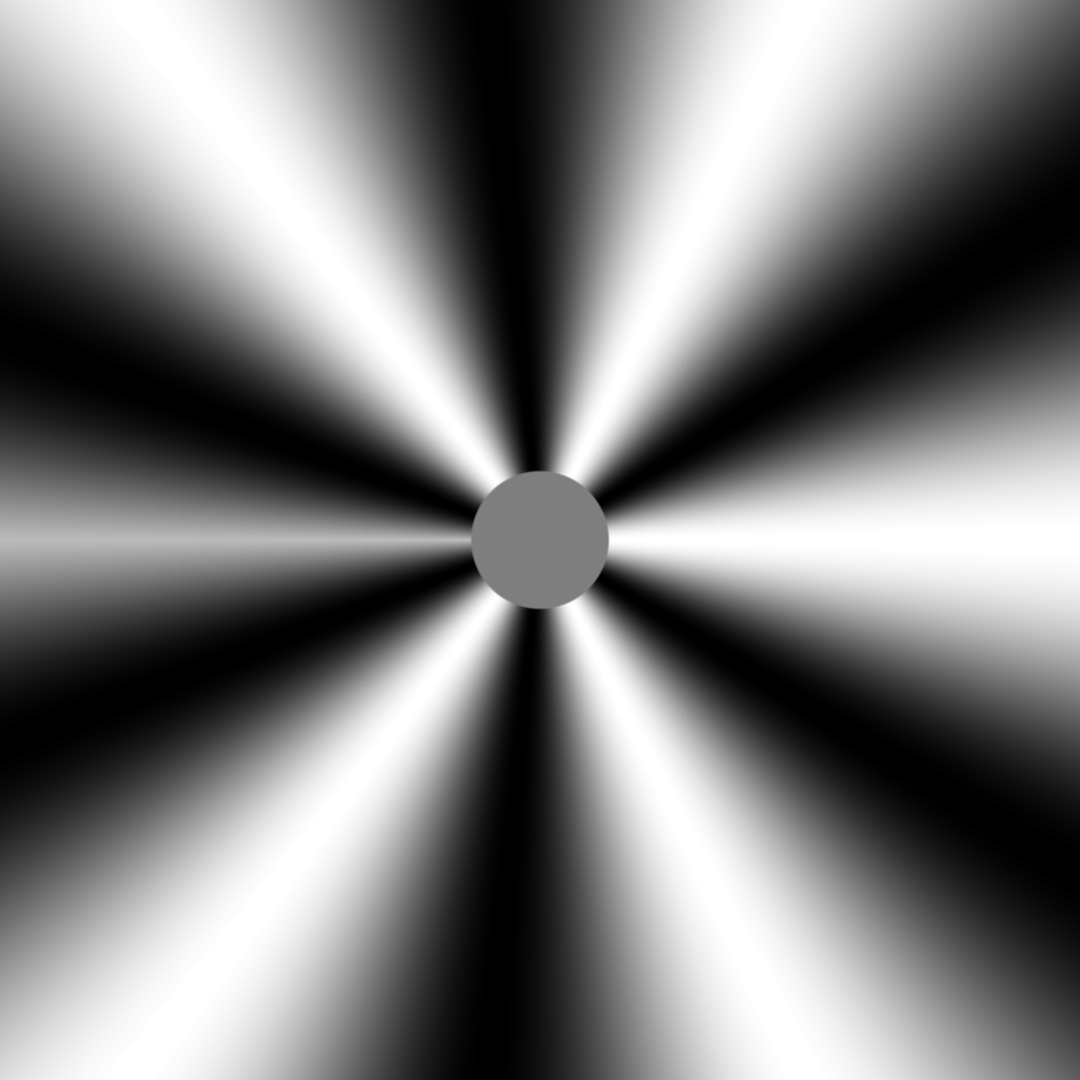
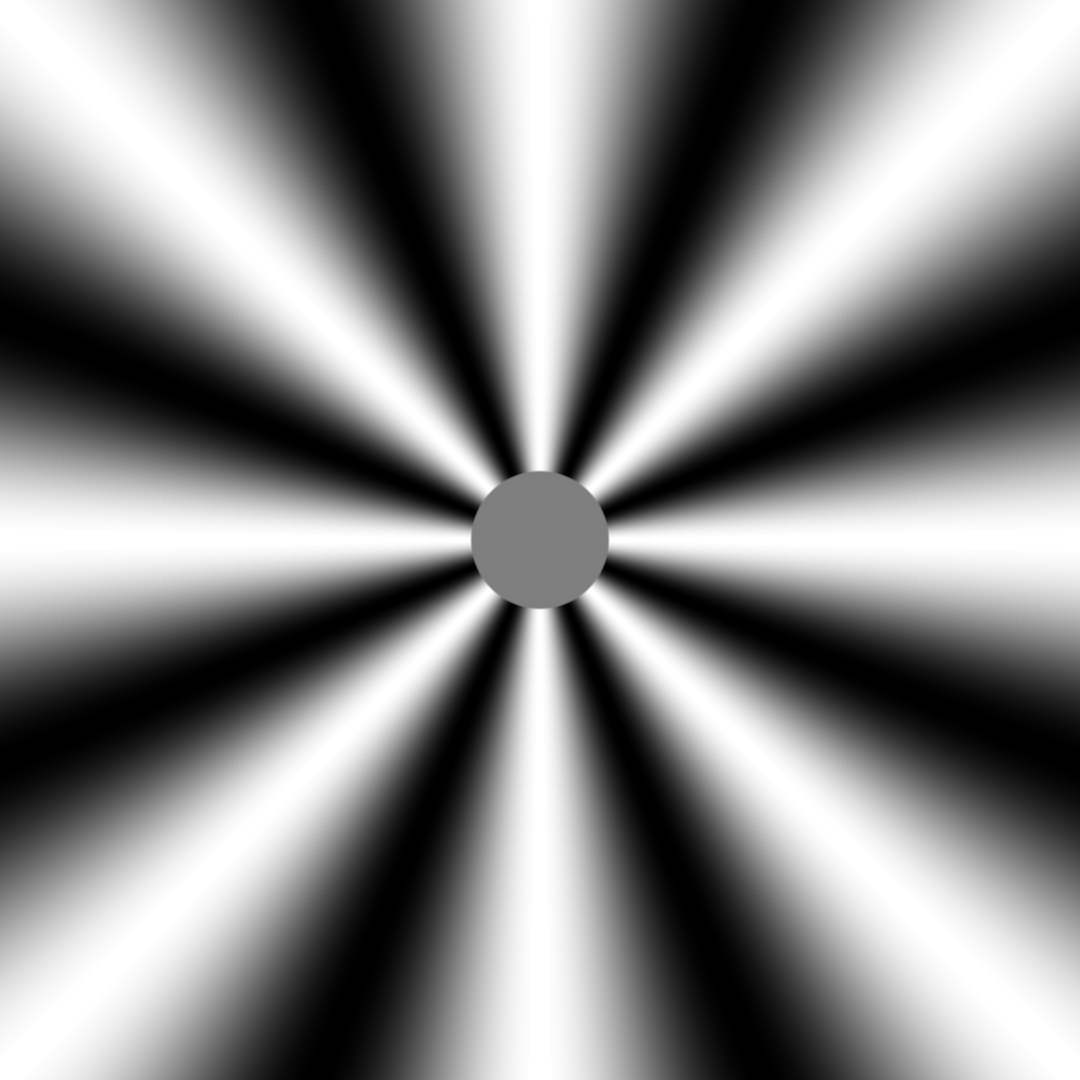
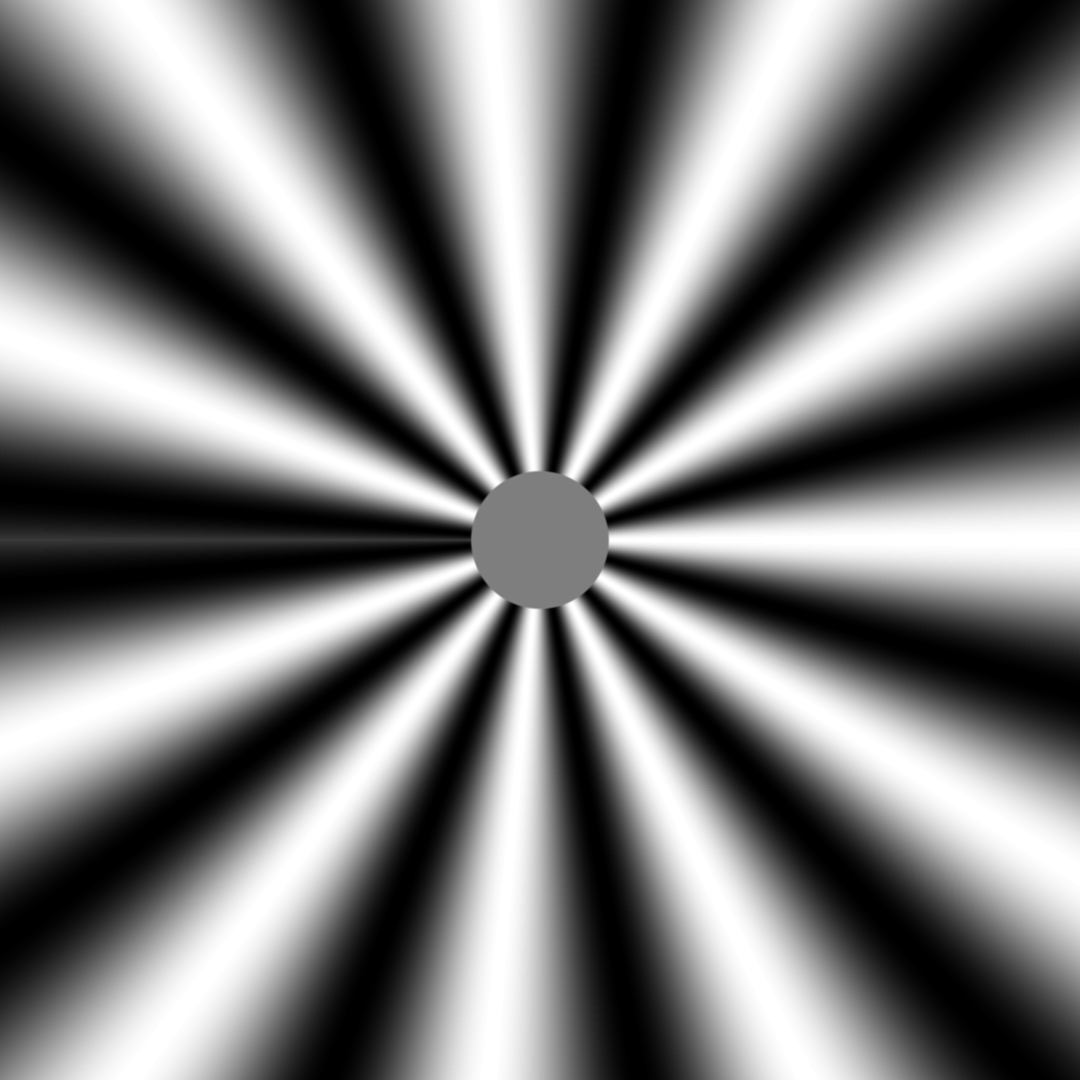
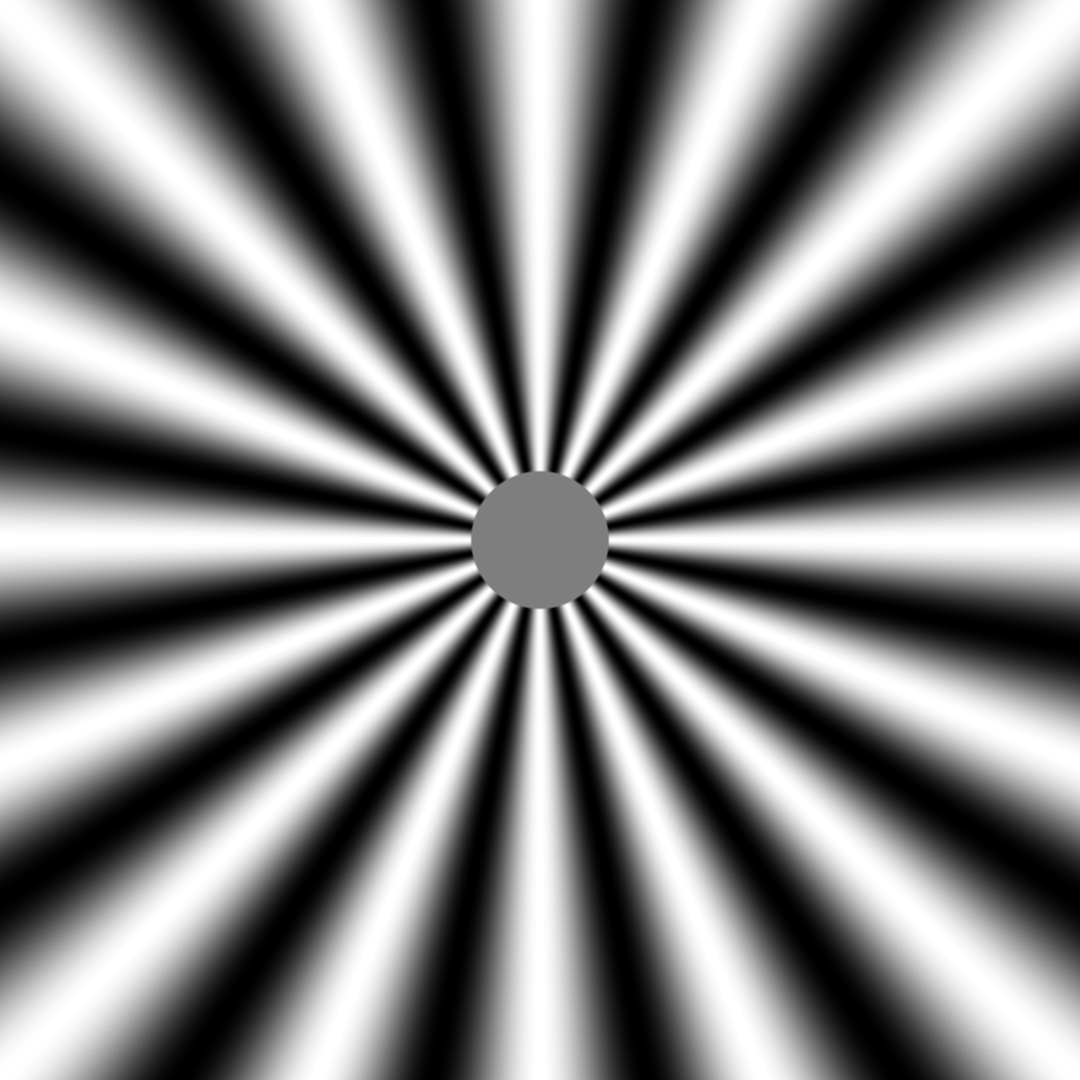

In [5]:
jbh.showIm([i for i in stim[0:4]], ncols=4)


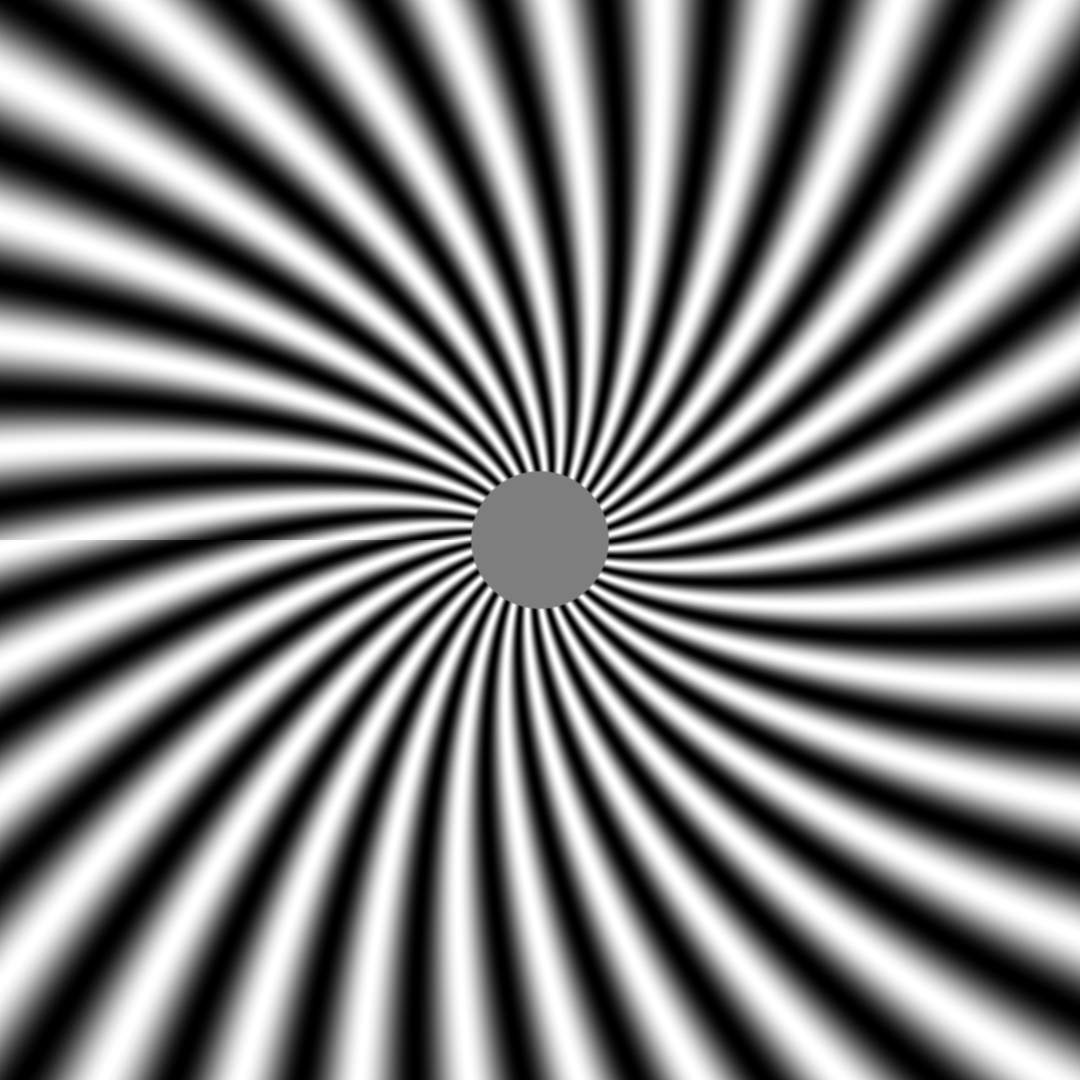
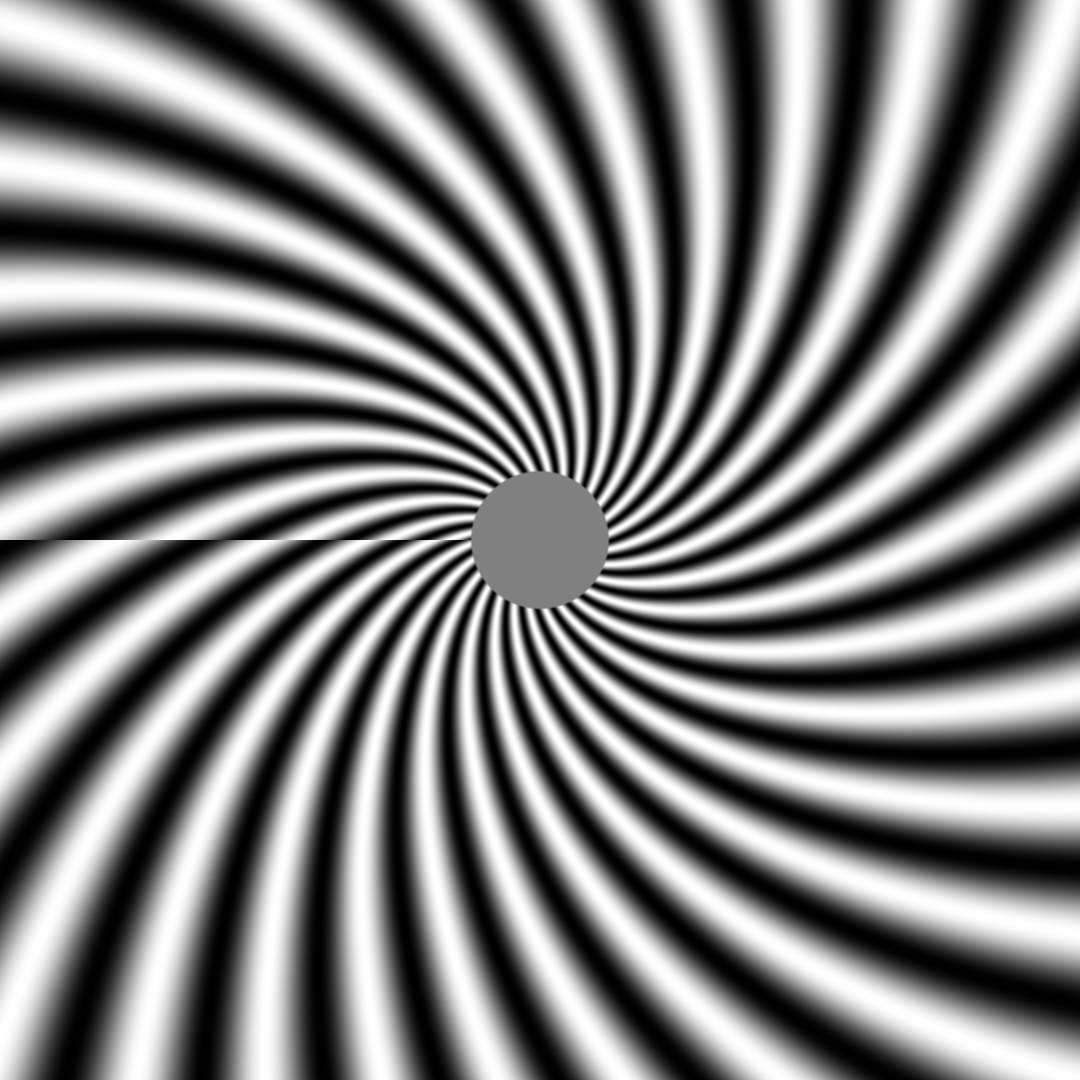
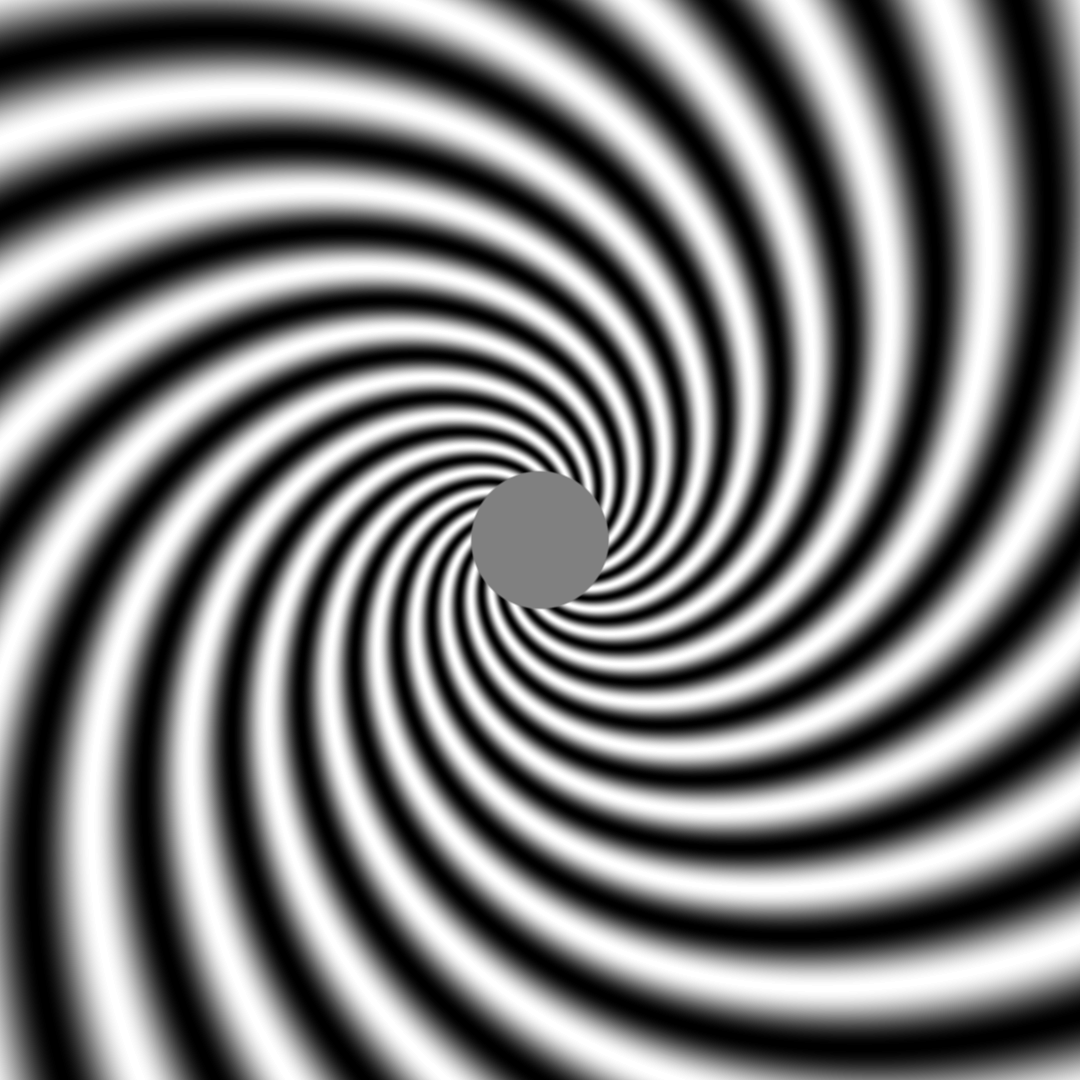
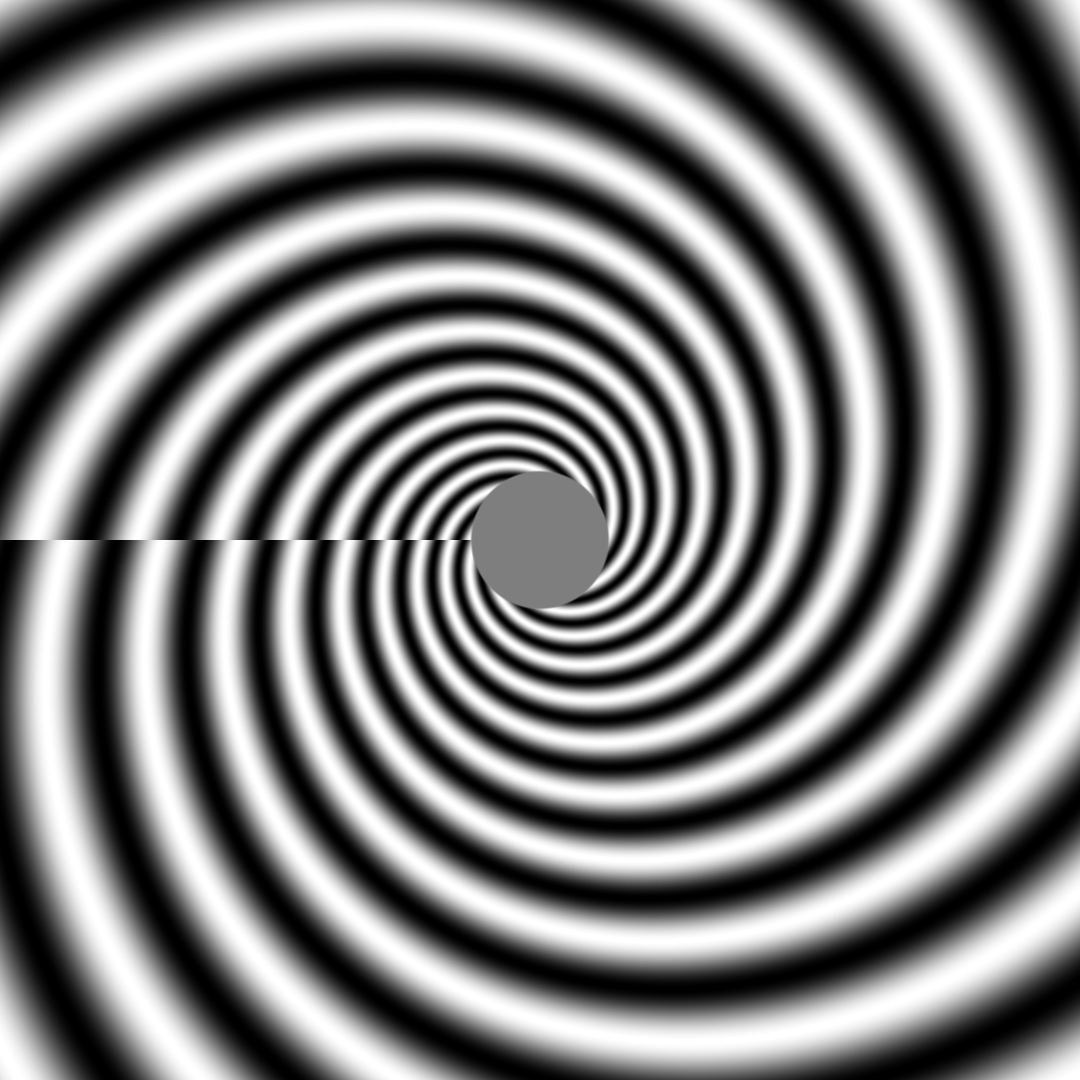

In [14]:
jbh.showIm([i for i in stim[-12:-8]], ncols=4)

In [23]:
stim.shape

(56, 1080, 1080)

In [25]:
np.save("../data/stimuli/test3.npy", stim[0,:,:])